<a href="https://colab.research.google.com/github/rokugatsu/HomeCreditDefaultRisk/blob/main/My_competition2_v112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk
このnotebookでは、予測結果を作成するまでの流れと基本的な手法についての紹介を行います。


まずは、今回のタスクについて確認しましょう（詳細はREADME.ipynbをご覧ください）。
- **目的**： 顧客データから債務不履行になる確率を予測する。
- **評価指標**： AUC（Area Under the Curve）

Omni: 0.74053

## 目次
0. ライブラリ・データの読み込み
1. データの可視化と分析
2. 前処理と特徴量作成
3. 機械学習モデルの作成
4. 予測結果の作成

## 0. ライブラリ・データの読み込み

基本的なライブラリを読み込みます。
他の必要なライブラリについては、説明をする際に読み込みます。
- numpy：数値計算を効率的に行うライブラリ
- pandas：データ分析に便利なライブラリ
- matplotlib：グラフ描画ライブラリ
- seaborn：グラフ描画ライブラリ

In [134]:
#pip install sweetviz

In [135]:
#import sweetviz as sv

In [136]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

必要なデータの読み込みを行います。GCIの教材フォルダの構成を想定して、読み込んでいます。

In [137]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
#%cd "/content/drive/MyDrive"
%cd "/content/drive/MyDrive/data/competition2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data/competition2


In [138]:
#Switch Kaggle or Omini
key_kaggle = True

In [139]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。
INPUT_DIR = "./input/"

if key_kaggle == True:
  #For kaggle
  train = pd.read_csv(INPUT_DIR + "application_train.csv")
  test  = pd.read_csv(INPUT_DIR + "application_test.csv")
  sample_sub = pd.read_csv(INPUT_DIR + "sample_submission_kaggle.csv")
else:
  #For Omni
  train = pd.read_csv(INPUT_DIR + "train.csv")
  test = pd.read_csv(INPUT_DIR + "test.csv")
  sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")

#sample_sub

## 1. データの可視化と分析

### 1.1 データの概観
本格的な分析を行う前に、まずは簡単にデータの概観を確認します。

In [140]:
# trainデータの確認
print(f"train shape: {train.shape}")
train.head(3)
#train.head(10)

train shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
# testデータの確認
print(f"test shape: {test.shape}")
train.head(3)
#test.head(10)

test shape: (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


特徴量が50種類もあることが分かります。このnotebookでは、50種類全ての特徴量について分析することはせず、5種類の特徴量に絞って分析を行います。今回のように特徴量が多い場合は、初めから全ての特徴量に対して、分析や前処理を行うのは大変だと思います。なので、初めは少ない特徴量で予測結果を出すことを目標に取り組んでみて、それから扱う特徴量を増やしてみると取り組みやすいです。残りの45種類の特徴量については、今までの教材やこのnotebook等を参考にして、自分の力で分析を行ってみてください。


使用する5種類の特徴量については、様々な処理の説明を行えるように選択しています。

In [142]:
test.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

sweetviz

In [143]:
#report = sv.analyze(train, target_feat="TARGET")

In [144]:
#report.show_notebook()

In [145]:
#report.show_html("eda.html")

In [146]:
# 5種類の特徴量に絞る
#use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "EXT_SOURCE_2", "OWN_CAR_AGE", "ORGANIZATION_TYPE"]
#target = train["TARGET"].values
#train = train[use_features]
#train["TARGET"] = target
#test = test[use_features]

In [147]:
# 5種類の特徴量に絞る
#use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","CNT_FAM_MEMBERS","NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE"]
#use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","CNT_FAM_MEMBERS","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_HOUSING_TYPE"]
#use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","CNT_FAM_MEMBERS","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE"]
#use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","CNT_FAM_MEMBERS","NAME_INCOME_TYPE","OCCUPATION_TYPE"]
#use_features = ["NAME_CONTRACT_TYPE","NAME_INCOME_TYPE","AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","OCCUPATION_TYPE","REGION_RATING_CLIENT","REGION_RATING_CLIENT_W_CITY"]
use_features = ["NAME_CONTRACT_TYPE","NAME_INCOME_TYPE","AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE","OCCUPATION_TYPE"]

target = train["TARGET"].values
train_ft = train[use_features]
train_ft["TARGET"] = target
test_ft = test[use_features]

再度、データの確認を行います。

In [148]:
# trainデータの確認
print(f"train shape: {train.shape}")
train_ft.head(10)

train shape: (307511, 122)


,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,OWN_CAR_AGE,ORGANIZATION_TYPE,OCCUPATION_TYPE,TARGET
0,Cash loans,Working,202500.0,NaN,Business Entity Type 3,Laborers,1
1,Cash loans,State servant,270000.0,NaN,School,Core staff,0
2,Revolving loans,Working,67500.0,26.0,Government,Laborers,0
3,Cash loans,Working,135000.0,NaN,Business Entity Type 3,Laborers,0
4,Cash loans,Working,121500.0,NaN,Religion,Core staff,0
5,Cash loans,State servant,99000.0,NaN,Other,Laborers,0
6,Cash loans,Commercial associate,171000.0,17.0,Business Entity Type 3,Accountants,0
7,Cash loans,State servant,360000.0,8.0,Other,Managers,0
8,Cash loans,Pensioner,112500.0,NaN,XNA,NaN,0
9,Revolving loans,Working,135000.0,NaN,Electricity,Laborers,0


In [149]:
# testデータの確認
print(f"test shape: {test.shape}")
test.head(3)

test shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


### 1.2 データの可視化・分析(EDA)
データを可視化して分析を行います。この作業では、特徴量の値の分布, 欠損値, 外れ値, 相関関係などの確認を行うことでデータへの理解を深めます。この段階で得られる分析結果を元に、前処理、特徴量の作成、機械学習モデルの選択などを行うので、最終的な予測に大きく影響する重要な作業となります。Kaggle上でも様々な方がEDAを行ったコードが公開されているので、参考にしてみると良いです。

#### 1.2.1 欠損値の確認
ここでは、欠損値の確認を行います。
ほとんどの機械学習モデルでは、欠損値があるデータで学習を行うことができません。そのため、何かしらの値で欠損値を埋める必要があるので、欠損値の確認を必ず行います。

#Examine Missing Values

Next we can look at the number and percentage of missing values in each column.


In [150]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [151]:
# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [152]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [153]:
# Number of unique classes in each object column
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [154]:
# trainの欠損値を確認
train.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [155]:
# testの欠損値を確認
test.isnull().sum()

SK_ID_CURR                       0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
AMT_REQ_CREDIT_BUREAU_YEAR    6049
Length: 121, dtype: int64

#Encoding Categorical Variables¶

Before we go any further, we need to deal with pesky categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

*   Label encoding
*   One-hot encoding


# Label Encoding and One-Hot Encoding¶

Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.


In [156]:
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [157]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [158]:
train_labels = train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


#### 1.2.2 各特徴量の可視化・分析
ここでは、各特徴量について可視化を行い、どのような特徴があるのか分析します。

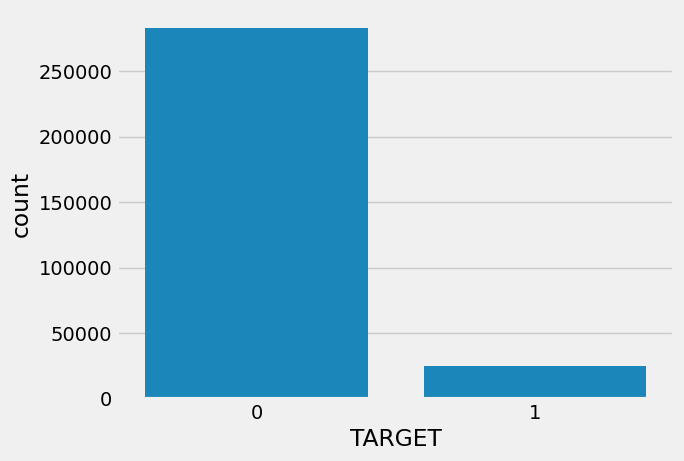

In [159]:
# 目的変数（債務不履行かどうか）の分布
sns.countplot(data=train, x="TARGET")
plt.show()

目的変数の分布が大きく偏っていることが分かります。このように目的変数の分布が大きく偏っているデータのことを不均衡データと呼びます。


不均衡データを扱う際は、特に評価指標の選び方に注意する必要があります。例えば、今回の評価指標として正解率（Accuracy）を選択すると、全て0と予測するだけで高正解率となることがわかると思います。このような適切でない評価指標を選択すると機械学習モデルがうまく学習できない原因となります。

また、不均衡データへの対処として、目的変数の分布を均衡にしようとするアプローチもあります。多い方の目的変数のデータを減らす手法をアンダーサンプリング、少ない方の目的変数のデータを増やす方法をオーバーサンプリングと呼びます。

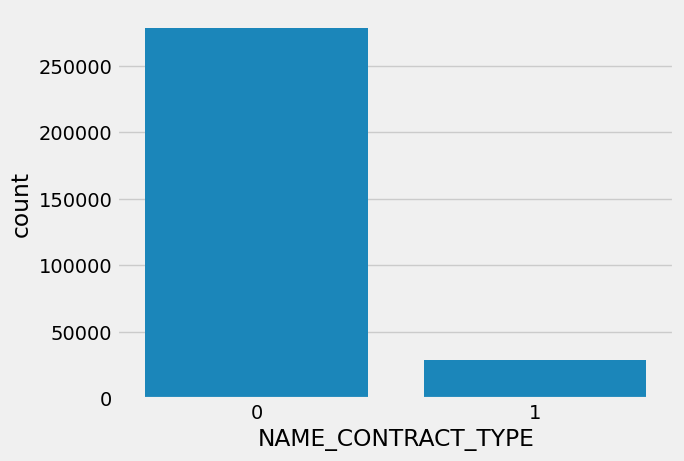

In [160]:
# NAME_CONTRACT_TYPE
sns.countplot(data=train, x="NAME_CONTRACT_TYPE")
plt.show()

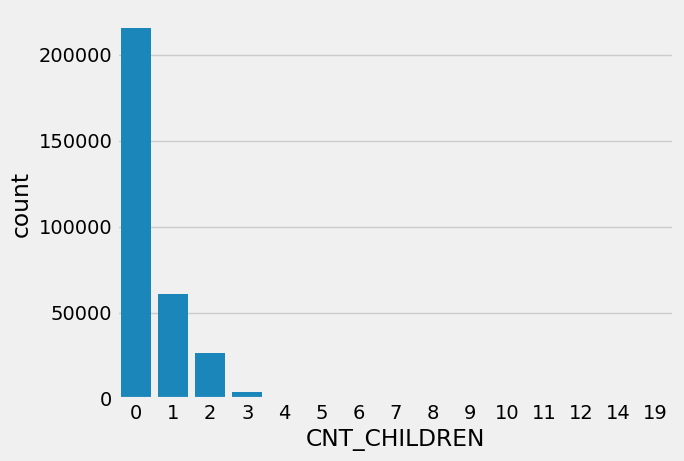

In [161]:
# CNT_CHILDREN
#sns.countplot(data=train, x="NAME_CONTRACT_TYPE")
sns.countplot(data=train, x="CNT_CHILDREN")
plt.show()

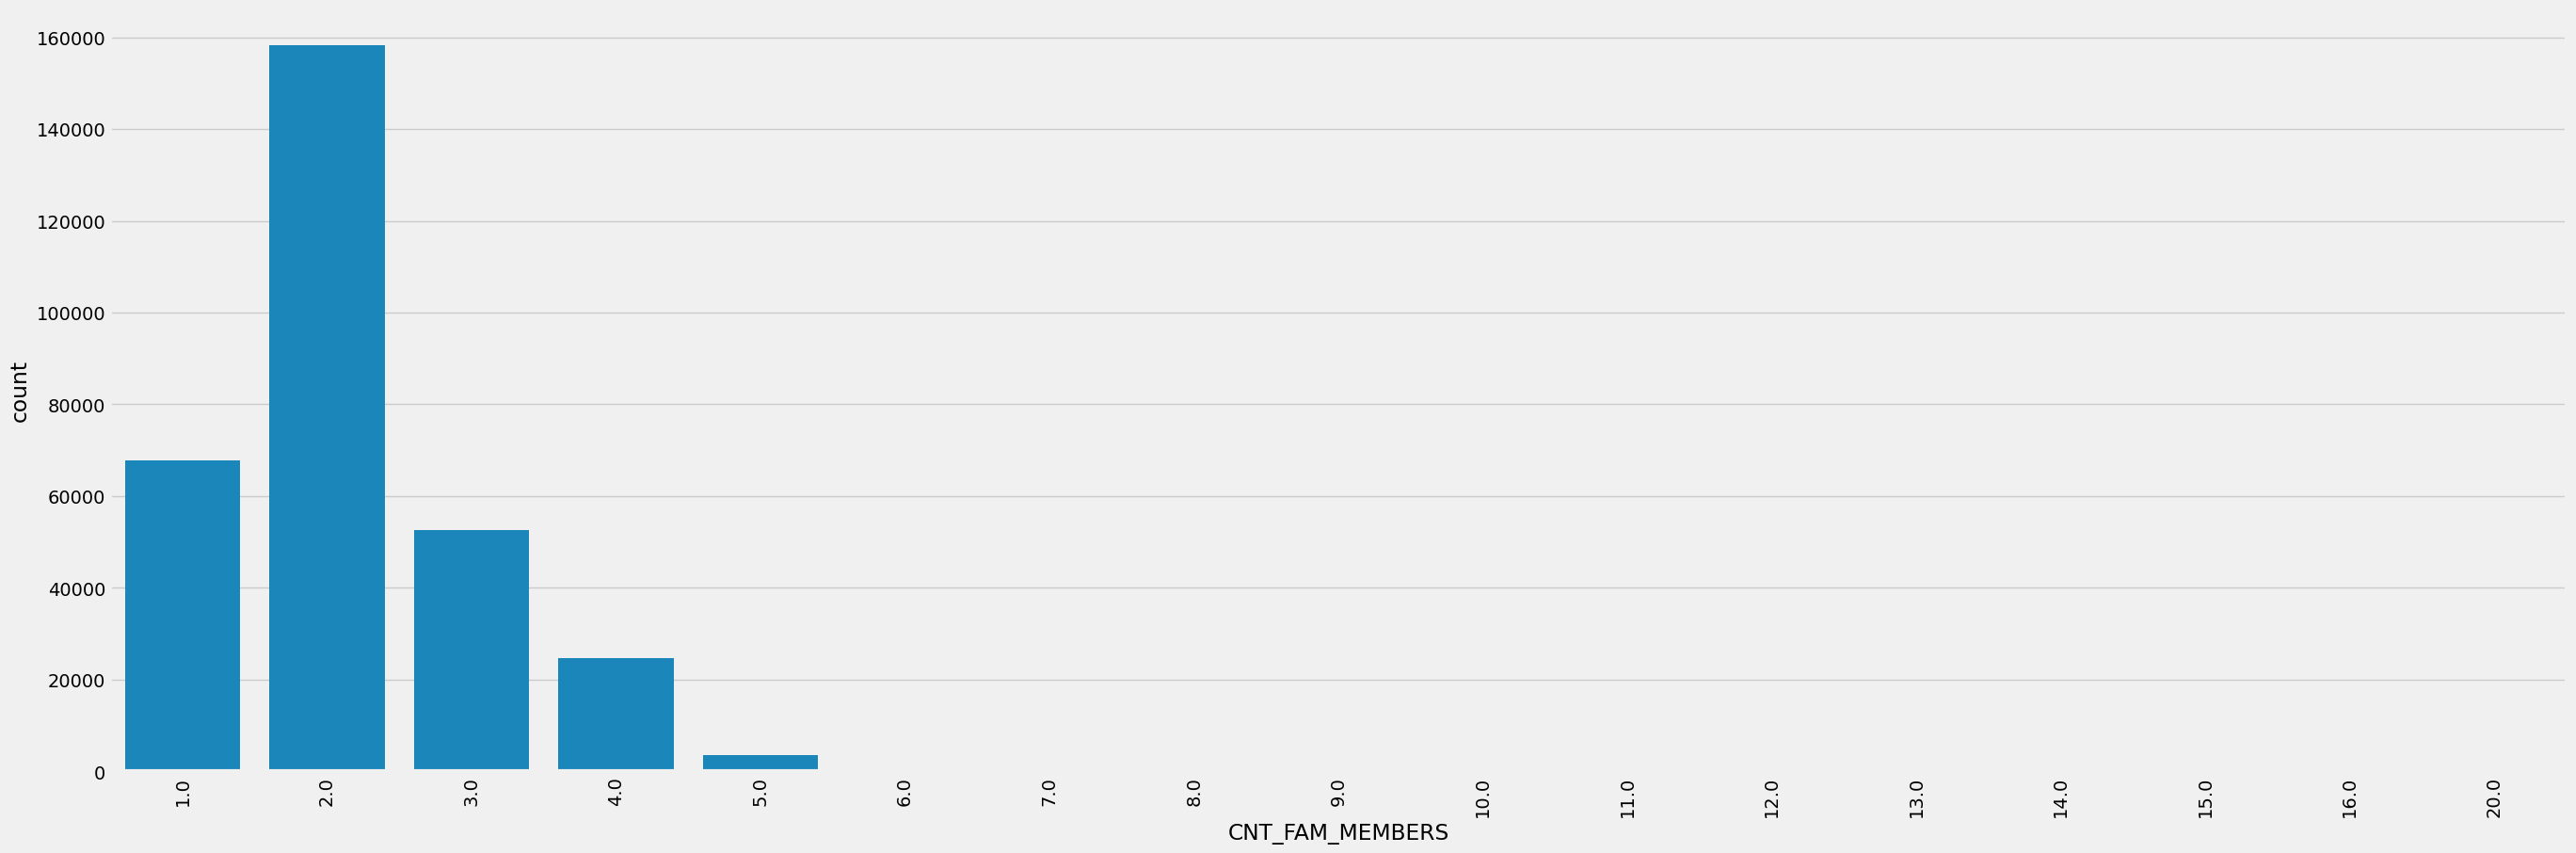

In [162]:
# CNT_FAM_MEMBERS
plt.figure(figsize=(30, 10))
sns.countplot(data=train, x="CNT_FAM_MEMBERS")
plt.tick_params(axis="x", rotation=90)
plt.show()

In [163]:
# DAYS_BIRTHの分布
#print((train['DAYS_BIRTH'] / -365).describe())
#train['DAYS_BIRTH'] = (train['DAYS_BIRTH'] / -365)
#sns.displot(data=train, x="DAYS_BIRTH")
#plt.show()

In [164]:
print(train['DAYS_EMPLOYED'].describe())

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


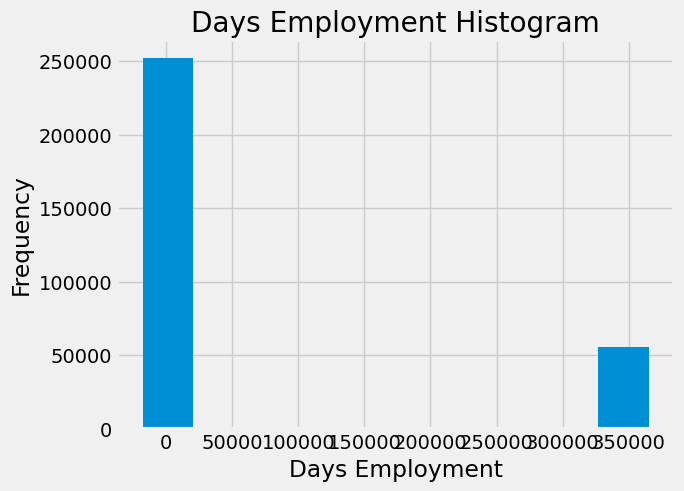

In [165]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [166]:
anom = train[train['DAYS_EMPLOYED'] == 365243]
non_anom = train[train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


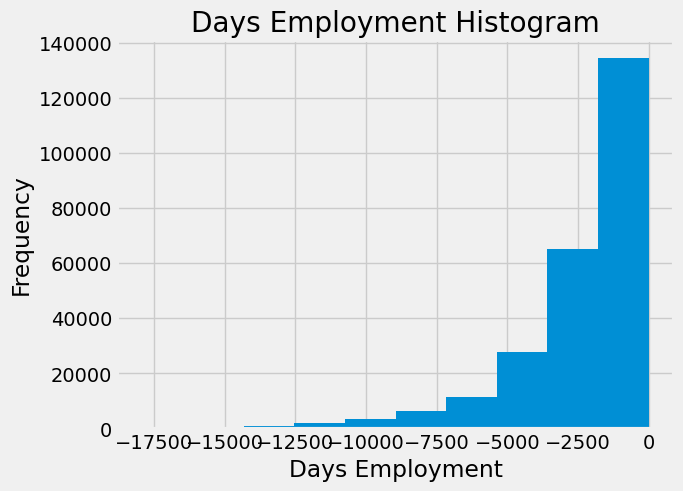

In [167]:
# Create an anomalous flag column
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [168]:
# ヒストグラムの描写
# x軸のラベルを指定
#plt.xlabel('DAYS_EMPLOYED', fontsize=15)
#plt.xlabel('hist', fontsize=15)
#plt.hist(x=train['DAYS_EMPLOYED'], bins=10, range=(-20000, 0))

In [169]:
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (test["DAYS_EMPLOYED_ANOM"].sum(), len(test)))

There are 9274 anomalies in the test data out of 48744 entries


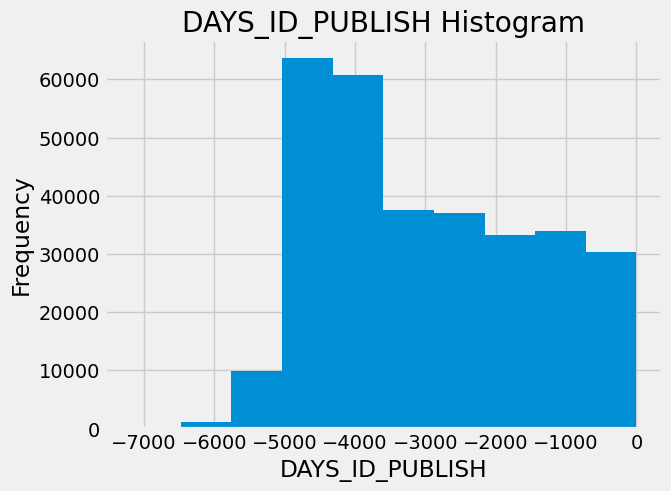

In [170]:
train['DAYS_ID_PUBLISH'].plot.hist(title = 'DAYS_ID_PUBLISH Histogram');
plt.xlabel('DAYS_ID_PUBLISH');

# Correlations¶

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

    .00-.19 “very weak”
    .20-.39 “weak”
    .40-.59 “moderate”
    .60-.79 “strong”
    .80-1.0 “very strong”



In [171]:
# Find correlations with the target and sort
correlations = train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [172]:
# Find the correlation of the positive days since birth and target
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
train['DAYS_BIRTH'].corr(train['TARGET'])

-0.07823930830982694

In [173]:
train['DAYS_EMPLOYED'] = abs(train['DAYS_EMPLOYED'])
train['DAYS_EMPLOYED'].corr(train['TARGET'])

-0.07495845742543872

In [174]:
train['DAYS_ID_PUBLISH'] = abs(train['DAYS_ID_PUBLISH'])
train['DAYS_ID_PUBLISH'].corr(train['TARGET'])

-0.05145717260705743

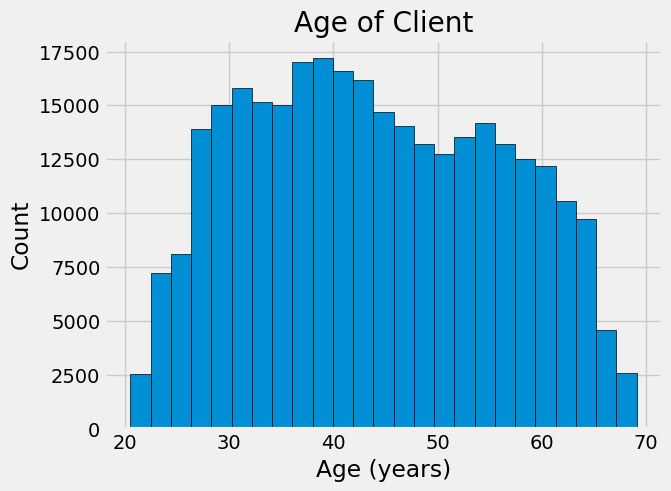

In [175]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

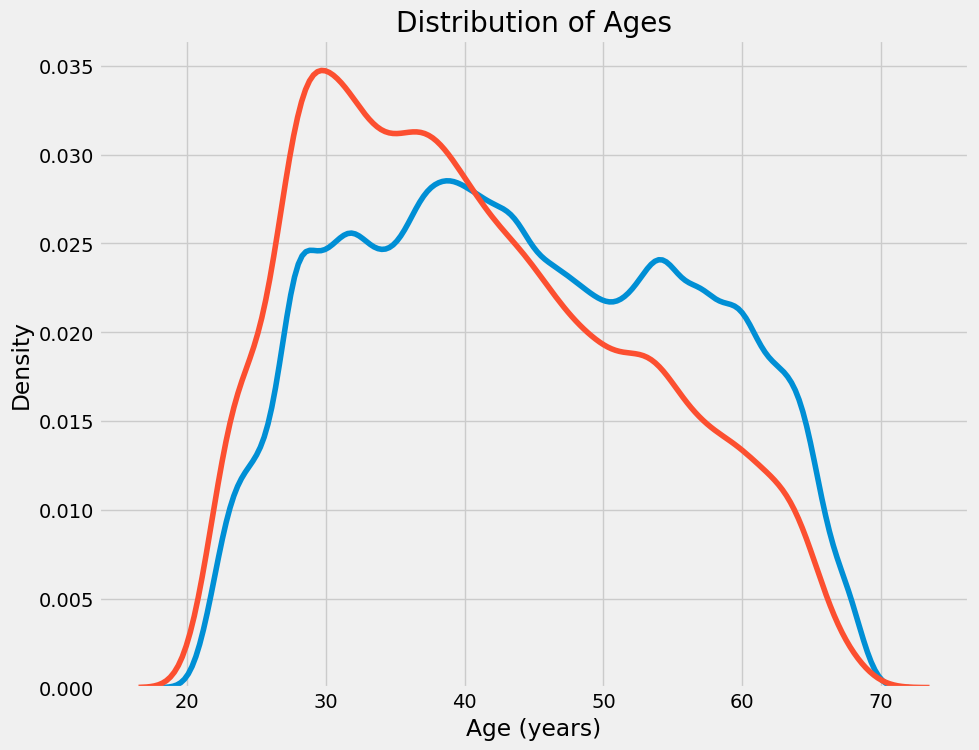

In [176]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = "target == 0")

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

<Axes: xlabel='OBS_60_CNT_SOCIAL_CIRCLE', ylabel='Density'>

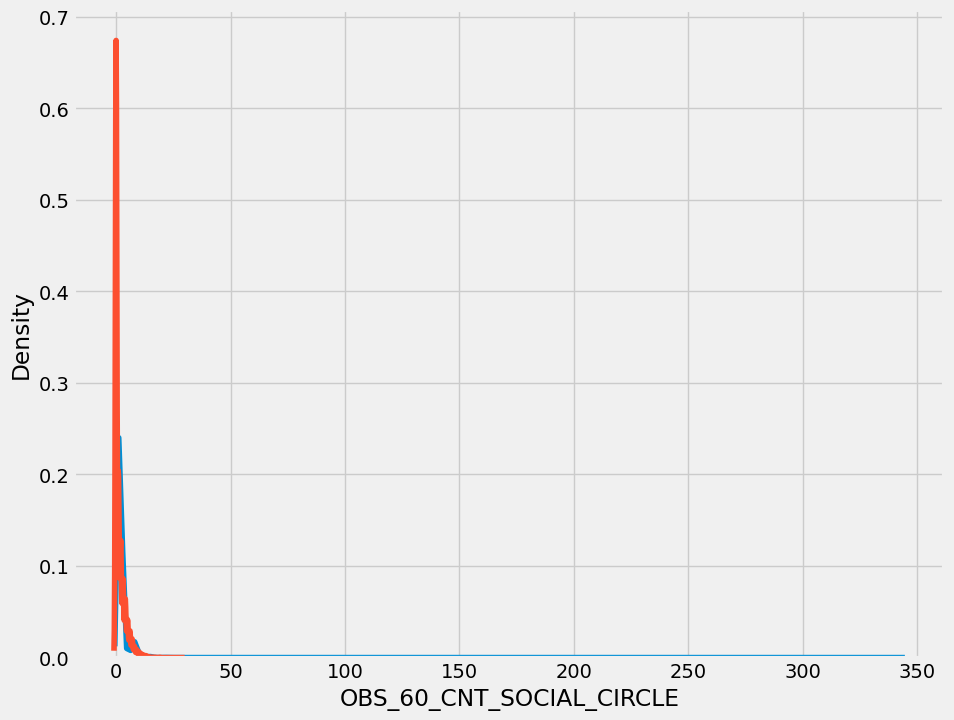

In [177]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'OBS_60_CNT_SOCIAL_CIRCLE'], label = "target == 0")

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'OBS_60_CNT_SOCIAL_CIRCLE'], label = 'target == 1')

# Labeling of plot
#plt.xlabel('years'); plt.ylabel('Density'); plt.title('Distribution of AMT_REQ_CREDIT_BUREAU_YEAR');

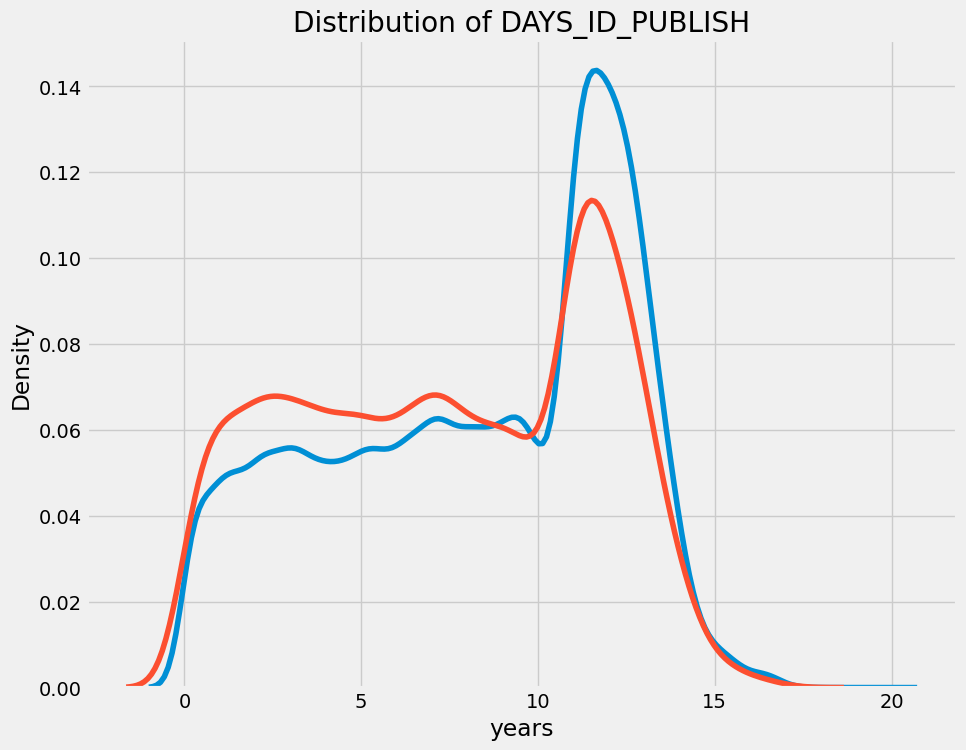

In [178]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_ID_PUBLISH'] / 365, label = "target == 0")

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_ID_PUBLISH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('years'); plt.ylabel('Density'); plt.title('Distribution of DAYS_ID_PUBLISH');

In [179]:
# Age information into a separate dataframe
age_data = train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [180]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


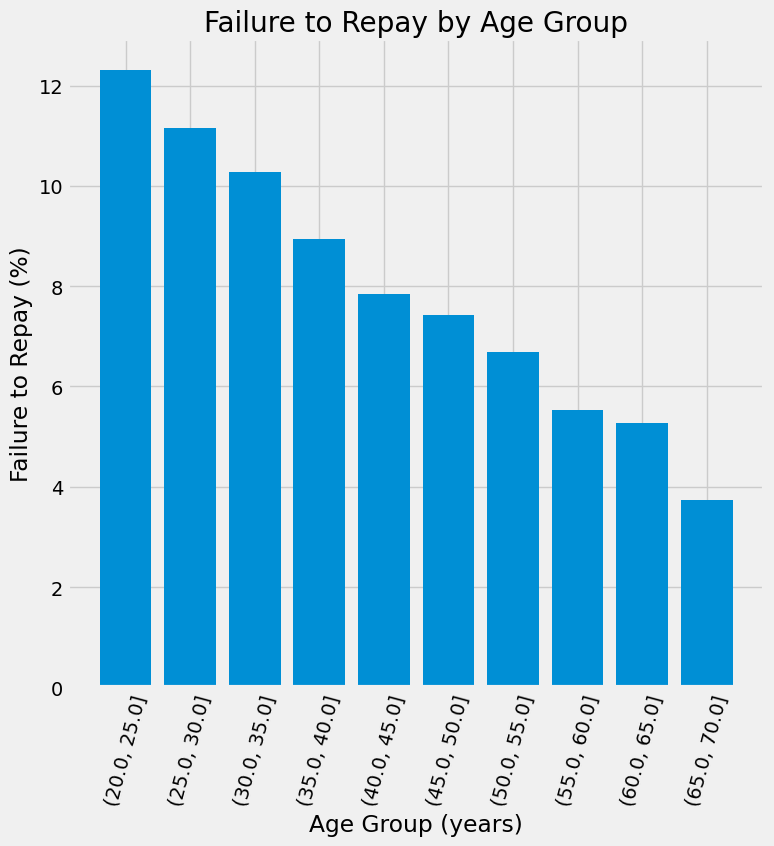

In [181]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.


#Exterior Sources¶

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.


In [182]:
#train['OBS_DEF_60'] = train['DEF_60_CNT_SOCIAL_CIRCLE'] /train['OBS_60_CNT_SOCIAL_CIRCLE']
#test['OBS_DEF_60'] = test['DEF_60_CNT_SOCIAL_CIRCLE'] /test['OBS_60_CNT_SOCIAL_CIRCLE']

train['DEF_OBS'] = (train['DEF_30_CNT_SOCIAL_CIRCLE'] + train['DEF_60_CNT_SOCIAL_CIRCLE']) / (train['OBS_30_CNT_SOCIAL_CIRCLE'] + train['OBS_60_CNT_SOCIAL_CIRCLE'])
test['DEF_OBS'] = (test['DEF_30_CNT_SOCIAL_CIRCLE'] + test['DEF_60_CNT_SOCIAL_CIRCLE']) / (test['OBS_30_CNT_SOCIAL_CIRCLE'] + test['OBS_60_CNT_SOCIAL_CIRCLE'])


In [183]:
# Extract the EXT_SOURCE variables and show correlations
#ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
#ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','DAYS_EMPLOYED']]
ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DEF_OBS','NAME_EDUCATION_TYPE_Higher education']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DEF_OBS,NAME_EDUCATION_TYPE_Higher education
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239,-0.074958,-0.051457,0.009308,0.009022,0.031276,0.041722,-0.056593
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610,0.252712,0.132375,-0.096569,-0.025351,-0.030508,-0.026619,0.135180
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996,0.093444,0.050955,-0.001823,-0.018878,-0.032340,-0.039475,0.124581
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478,0.129722,0.131597,-0.027964,-0.000717,-0.034096,-0.049632,-0.022429
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000,0.352321,0.272691,-0.278894,-0.007023,-0.001925,0.004223,-0.115808
DAYS_EMPLOYED,-0.074958,0.252712,0.093444,0.129722,0.352321,1.000000,0.089869,-0.028872,0.002011,-0.011108,-0.019765,-0.003662
DAYS_ID_PUBLISH,-0.051457,0.132375,0.050955,0.131597,0.272691,0.089869,1.000000,0.020912,0.012874,-0.004328,-0.012537,-0.025781
CNT_FAM_MEMBERS,0.009308,-0.096569,-0.001823,-0.027964,-0.278894,-0.028872,0.020912,1.000000,0.024971,-0.004749,-0.023395,0.025229
OBS_60_CNT_SOCIAL_CIRCLE,0.009022,-0.025351,-0.018878,-0.000717,-0.007023,0.002011,0.012874,0.024971,1.000000,0.255570,-0.161565,-0.045448
DEF_60_CNT_SOCIAL_CIRCLE,0.031276,-0.030508,-0.032340,-0.034096,-0.001925,-0.011108,-0.004328,-0.004749,0.255570,1.000000,0.743687,-0.031354


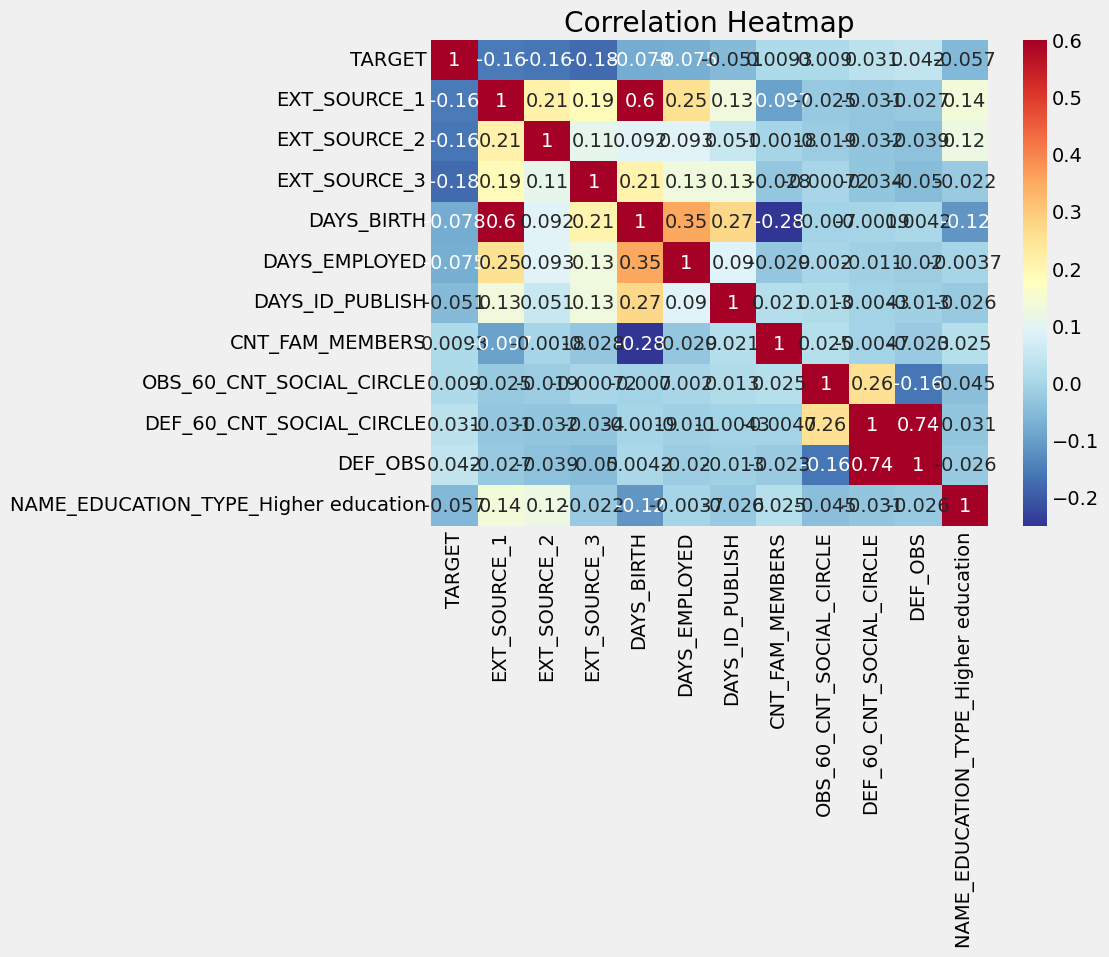

In [184]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

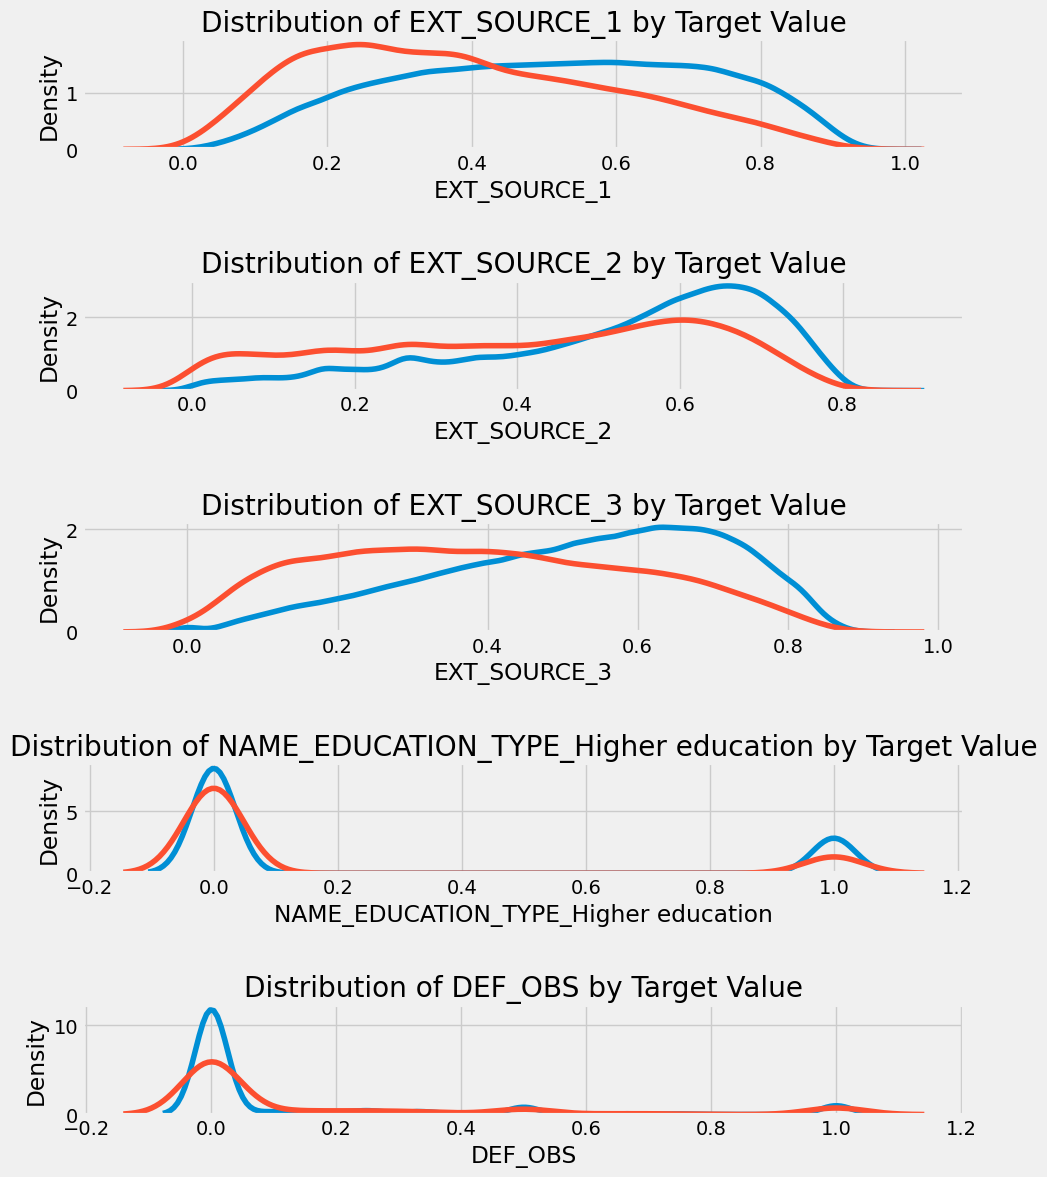

In [185]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','NAME_EDUCATION_TYPE_Higher education','DEF_OBS']):

    # create a new subplot for each source
    plt.subplot(5, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

In [186]:
# Copy the data for plotting
#plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
#plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
#plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
#def corr_func(x, y, **kwargs):
#    r = np.corrcoef(x, y)[0][1]
#    ax = plt.gca()
#    ax.annotate("r = {:.2f}".format(r),
#                xy=(.2, .8), xycoords=ax.transAxes,
#                size = 20)

# Create the pairgrid object
#grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
#                    hue = 'TARGET',
#                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

#grid = sns.PairGrid(data = plot_data, diag_sharey=False,
#                    hue = 'TARGET',
#                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])


# Upper is a scatter plot
#grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
#grid.map_diag(sns.kdeplot)

# Bottom is density plot
#grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

#plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

AMT_INCOME_TOTALは、通常通り可視化してもうまくグラフが表示されていません。このような場合には、大きな数値を取る少数の外れ値が存在することが原因であると考えられます。今回のようなデータを可視化したい場合は、対数変換を行うと上手くグラフを表示することができます。

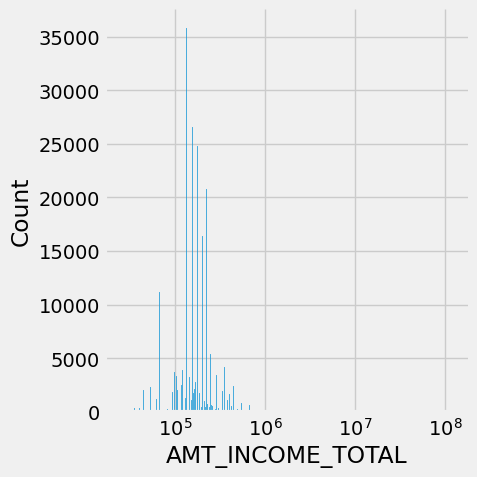

In [187]:
# AMT_INCOME_TOTALの分布（対数変換）
sns.displot(data=train, x="AMT_INCOME_TOTAL", log_scale=10)
plt.show()

対数変換してグラフを描画することで、うまく表示することができました。しかし、年収というのは本来連続的な値を取るはずなのに、グラフをみると離散的な値をとっているようです。AMT_INCOME_TOTALの値の種類を確認してみましょう。

In [188]:
# AMT_INCOME_TOTALの値の種類を確認
len(train["AMT_INCOME_TOTAL"].unique())

2548

In [189]:
len(train["NAME_EDUCATION_TYPE_Higher education"].unique())

2

trainには171202個のデータが存在するのですが、AMT_INCOME_TOTALは1641種類の値のみで構成されています。具体的に上位10個の値を確認してみましょう。

In [190]:
# AMT_INCOME_TOTALの上位10個
train["AMT_INCOME_TOTAL"].value_counts().head(10)

AMT_INCOME_TOTAL
135000.0    35750
112500.0    31019
157500.0    26556
180000.0    24719
90000.0     22483
225000.0    20698
202500.0    16341
67500.0     11147
270000.0    10827
81000.0      6001
Name: count, dtype: int64

どうやらAMT_INCOME_TOTALは正確な年収ではなく、きりの良い数字で集計されたデータであることが分かりました。

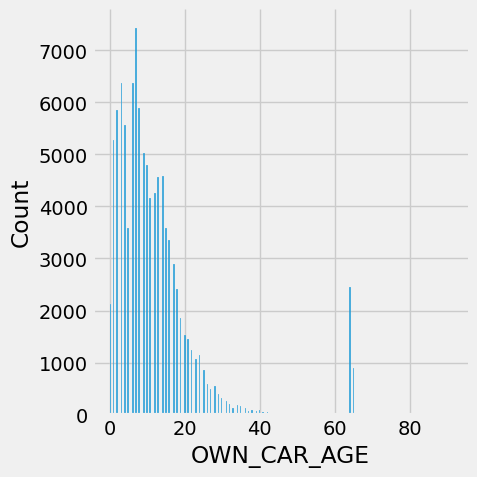

In [191]:
# OWN_CAR_AGEの分布
sns.displot(data=train, x="OWN_CAR_AGE")
plt.show()

OWN_CAR_AGEは、値のスケールから年単位の値をとっていることが推測できます。また、0〜40あたりまでは自然な分布ですが、60〜70付近に不自然な分布が存在していることが分かります。車の購入年数がこのように急に値が上昇するとは、考えにくいので外れ値であると考えられます。

ここまで、各特徴量の可視化と分析を行いました。可視化をするのにも工夫が必要だったり、可視化を行うことでデータについての理解が深まることが実感できたと思います。今回扱っていない45種類の特徴量についても、今回の可視化などを参考に各自で可視化・分析を行ってみることで、必ず予測精度の向上につながると思います。

## 2. 前処理と特徴量作成
ここでは、上記の可視化と分析でわかったことを踏まえて、前処理と特徴量の作成を行います。

In [192]:
# NAME_INCOME_TYPEの数値化（Count Encoding）
#name_type_suite_ce = train_ft["NAME_TYPE_SUITE"].value_counts()
#train_ft["NAME_TYPE_SUITE"] = train_ft["NAME_TYPE_SUITE"].map(name_type_suite_ce)
#test_ft["NAME_TYPE_SUITE"] = test_ft["NAME_TYPE_SUITE"].map(name_type_suite_ce)


In [193]:
#train_ft['NAME_TYPE_SUITE'].corr(train['TARGET'])

In [194]:
# NAME_CONTRACT_TYPEの数値化（Label Encoding）
train_ft["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)
test_ft["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)

train_ft.head(5)

,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,OWN_CAR_AGE,ORGANIZATION_TYPE,OCCUPATION_TYPE,TARGET
0,0,Working,202500.0,NaN,Business Entity Type 3,Laborers,1
1,0,State servant,270000.0,NaN,School,Core staff,0
2,1,Working,67500.0,26.0,Government,Laborers,0
3,0,Working,135000.0,NaN,Business Entity Type 3,Laborers,0
4,0,Working,121500.0,NaN,Religion,Core staff,0


In [195]:
# NAME_INCOME_TYPEの数値化（Count Encoding）
name_income_type_ce = train_ft["NAME_INCOME_TYPE"].value_counts()
train_ft["NAME_INCOME_TYPE"] = train_ft["NAME_INCOME_TYPE"].map(name_income_type_ce)
test_ft["NAME_INCOME_TYPE"] = test_ft["NAME_INCOME_TYPE"].map(name_income_type_ce)

train_ft.head(5)

,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,OWN_CAR_AGE,ORGANIZATION_TYPE,OCCUPATION_TYPE,TARGET
0,0,158774,202500.0,NaN,Business Entity Type 3,Laborers,1
1,0,21703,270000.0,NaN,School,Core staff,0
2,1,158774,67500.0,26.0,Government,Laborers,0
3,0,158774,135000.0,NaN,Business Entity Type 3,Laborers,0
4,0,158774,121500.0,NaN,Religion,Core staff,0


In [196]:
train_ft['NAME_INCOME_TYPE'].corr(train['TARGET'])

0.05984443249640598

In [197]:
# ORGANIZATION_TYPEの数値化（Count Encoding）
organization_ce = train_ft["ORGANIZATION_TYPE"].value_counts()
train_ft["ORGANIZATION_TYPE"] = train_ft["ORGANIZATION_TYPE"].map(organization_ce)
test_ft["ORGANIZATION_TYPE"] = test_ft["ORGANIZATION_TYPE"].map(organization_ce)

train_ft.head(5)

,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,OWN_CAR_AGE,ORGANIZATION_TYPE,OCCUPATION_TYPE,TARGET
0,0,158774,202500.0,NaN,67992,Laborers,1
1,0,21703,270000.0,NaN,8893,Core staff,0
2,1,158774,67500.0,26.0,10404,Laborers,0
3,0,158774,135000.0,NaN,67992,Laborers,0
4,0,158774,121500.0,NaN,85,Core staff,0


In [198]:
occupation_type_ce = train_ft["OCCUPATION_TYPE"].value_counts()
train_ft["OCCUPATION_TYPE"] = train_ft["OCCUPATION_TYPE"].map(organization_ce)
test_ft["OCCUPATION_TYPE"] = test_ft["OCCUPATION_TYPE"].map(organization_ce)

In [199]:
# OWN_CAR_AGEの60以上の値（外れ値）を欠損値扱いする
train_ft.loc[train["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
test_ft.loc[test["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan

In [200]:
# OWN_CAR_AGEをグループ分け
train_ft["OWN_CAR_AGE"] = train_ft["OWN_CAR_AGE"] // 10
test_ft["OWN_CAR_AGE"] = test_ft["OWN_CAR_AGE"] // 10

train_ft["OWN_CAR_AGE"].unique()

array([nan,  2.,  1.,  0.,  3.,  4.,  5.])

In [201]:
# OWN_CAR_AGEをOne Hot Encoding
train_car_age_ohe = pd.get_dummies(train["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(test["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")

train_ft = pd.concat([train_ft, train_car_age_ohe], axis=1)
test_ft = pd.concat([test_ft, test_car_age_ohe], axis=1)

train_ft.drop('OWN_CAR_AGE', axis=1, inplace=True)
test_ft.drop('OWN_CAR_AGE', axis=1, inplace=True)

train_ft.head(5)

,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,ORGANIZATION_TYPE,OCCUPATION_TYPE,TARGET,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,...,OWN_CAR_AGE_52.0,OWN_CAR_AGE_54.0,OWN_CAR_AGE_55.0,OWN_CAR_AGE_56.0,OWN_CAR_AGE_57.0,OWN_CAR_AGE_63.0,OWN_CAR_AGE_64.0,OWN_CAR_AGE_65.0,OWN_CAR_AGE_69.0,OWN_CAR_AGE_91.0
0,0,158774,202500.0,67992,NaN,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,21703,270000.0,8893,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,158774,67500.0,10404,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,158774,135000.0,67992,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,158774,121500.0,85,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [202]:
test_ft.head(5)

,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,ORGANIZATION_TYPE,OCCUPATION_TYPE,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,...,OWN_CAR_AGE_42.0,OWN_CAR_AGE_43.0,OWN_CAR_AGE_44.0,OWN_CAR_AGE_49.0,OWN_CAR_AGE_50.0,OWN_CAR_AGE_52.0,OWN_CAR_AGE_55.0,OWN_CAR_AGE_56.0,OWN_CAR_AGE_65.0,OWN_CAR_AGE_74.0
0,0,158774,135000.0,6880,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,158774,99000.0,38412,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,158774,202500.0,1187,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,158774,315000.0,67992,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,158774,180000.0,67992,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Domain 特徴

In [203]:
train_domain = train.copy()
test_domain = test.copy()

train_domain['AMT_INCOME_TOTAL'].fillna(train_domain.AMT_INCOME_TOTAL.mean(),inplace=True)
train_domain['AMT_ANNUITY'].fillna(train_domain.AMT_ANNUITY.mean(),inplace=True)
train_domain['AMT_CREDIT'].fillna(train_domain.AMT_CREDIT.mean(),inplace=True)
train_domain['AMT_GOODS_PRICE'].fillna(train_domain.AMT_GOODS_PRICE.mean(),inplace=True)

train_domain['DAYS_BIRTH'].fillna(train_domain.DAYS_BIRTH.mean(),inplace=True)
train_domain['DAYS_EMPLOYED'].fillna(train_domain.DAYS_EMPLOYED.mean(),inplace=True)
train_domain['DAYS_ID_PUBLISH_PERCENT'] = train_domain['DAYS_ID_PUBLISH'] / train_domain['DAYS_BIRTH']

train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL'] #NG
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']
train_domain['AMT_GOODS_PRICE_PERCENT'] = train_domain['AMT_GOODS_PRICE'] / train_domain['AMT_INCOME_TOTAL']


train['CREDIT_TERM']=train_domain['CREDIT_TERM']
train_domain.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'EMERGENCYSTATE_MODE_Yes', 'TARGET', 'DAYS_EMPLOYED_ANOM', 'DEF_OBS',
       'DAYS_ID_PUBLISH_PERCENT', 'CREDIT_INCOME_PERCENT',
       'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT',
       'AMT_GOODS_PRICE_PERCENT'],
      dtype='object', length=248)

In [204]:
from scipy import stats
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["CREDIT_INCOME_PERCENT"]
                , train_domain[train_domain["TARGET"]==0]["CREDIT_INCOME_PERCENT"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

0.3187524307279678


False

In [205]:
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["ANNUITY_INCOME_PERCENT"]
                , train_domain[train_domain["TARGET"]==0]["ANNUITY_INCOME_PERCENT"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

1.5875551034763828e-24


True

In [206]:
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["CREDIT_TERM"]
                , train_domain[train_domain["TARGET"]==0]["CREDIT_TERM"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

3.4061968216732806e-63


True

In [207]:
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["DAYS_EMPLOYED_PERCENT"]
                , train_domain[train_domain["TARGET"]==0]["DAYS_EMPLOYED_PERCENT"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

1.263079263689559e-237


True

In [208]:
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["AMT_GOODS_PRICE_PERCENT"]
                , train_domain[train_domain["TARGET"]==0]["AMT_GOODS_PRICE_PERCENT"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

2.7612916473500115e-13


True

In [209]:
s, pvalue = stats.mannwhitneyu(train_domain[train_domain["TARGET"]==1]["DAYS_ID_PUBLISH_PERCENT"]
                , train_domain[train_domain["TARGET"]==0]["DAYS_ID_PUBLISH_PERCENT"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

4.076286669254247e-10


True

In [210]:
test_domain['AMT_INCOME_TOTAL'].fillna(test_domain.AMT_INCOME_TOTAL.mean(),inplace=True)
test_domain['AMT_ANNUITY'].fillna(test_domain.AMT_ANNUITY.mean(),inplace=True)
test_domain['AMT_CREDIT'].fillna(test_domain.AMT_CREDIT.mean(),inplace=True)
test_domain['DAYS_BIRTH'].fillna(test_domain.DAYS_BIRTH.mean(),inplace=True)
test_domain['DAYS_EMPLOYED'].fillna(test_domain.DAYS_EMPLOYED.mean(),inplace=True)

#test_domain['CREDIT_INCOME_PERCENT'] = test_domain['AMT_CREDIT'] / test_domain['AMT_INCOME_TOTAL']
test_domain['ANNUITY_INCOME_PERCENT'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_INCOME_TOTAL']
test_domain['CREDIT_TERM'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_CREDIT']
test_domain['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED'] / test_domain['DAYS_BIRTH']
test_domain['AMT_GOODS_PRICE_PERCENT'] = test_domain['AMT_GOODS_PRICE'] / test_domain['AMT_INCOME_TOTAL']


test_domain['DAYS_ID_PUBLISH_PERCENT'] = test_domain['DAYS_ID_PUBLISH'] / test_domain['DAYS_BIRTH']

test['CREDIT_TERM']=test_domain['CREDIT_TERM']

In [211]:
train_domain.isnull().sum()

SK_ID_CURR                 0
NAME_CONTRACT_TYPE         0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
                          ..
CREDIT_INCOME_PERCENT      0
ANNUITY_INCOME_PERCENT     0
CREDIT_TERM                0
DAYS_EMPLOYED_PERCENT      0
AMT_GOODS_PRICE_PERCENT    0
Length: 248, dtype: int64

Polynomial features

Domain knowledge features

TARGET
0    Axes(0.08,0.07;0.87x0.81)
1    Axes(0.08,0.07;0.87x0.81)
Name: EXT_SOURCE_1, dtype: object

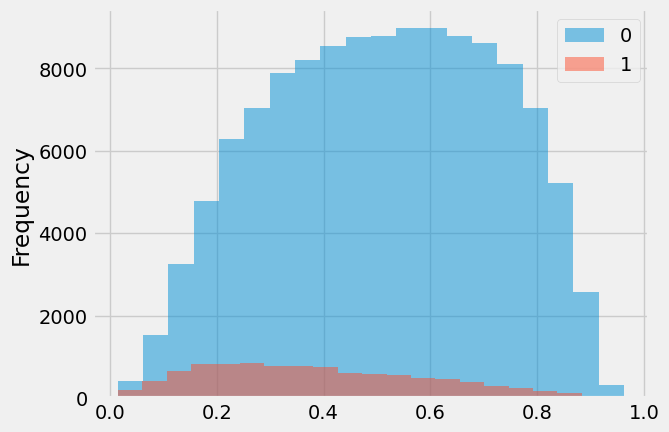

In [212]:
train.groupby('TARGET')['EXT_SOURCE_1'].plot.hist(bins=20, alpha=0.5, legend=True)

In [213]:
# Make a new dataframe for polynomial features
train['EXT_SOURCE_1'].fillna(train.EXT_SOURCE_1.mean(),inplace=True)
train['EXT_SOURCE_2'].fillna(train.EXT_SOURCE_2.mean(),inplace=True)
train['EXT_SOURCE_3'].fillna(train.EXT_SOURCE_3.mean(),inplace=True)

test['EXT_SOURCE_1'].fillna(test.EXT_SOURCE_1.mean(),inplace=True)
test['EXT_SOURCE_2'].fillna(test.EXT_SOURCE_2.mean(),inplace=True)
test['EXT_SOURCE_3'].fillna(test.EXT_SOURCE_3.mean(),inplace=True)

poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH','TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH']]

# imputer for handling missing values
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

#imputer = Imputer(strategy = 'median')
#imputer = SimpleImputer(strategy = 'median')
#imputer = SimpleImputer(strategy='constant', fill_value=-1.0)
imputer = SimpleImputer(strategy='most_frequent')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [214]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)
print('Polynomial Features test shape: ', poly_features_test.shape)

Polynomial Features shape:  (307511, 35)
Polynomial Features test shape:  (48744, 35)


In [215]:
poly_transformer.get_feature_names_out(input_features = [ 'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [216]:
# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features,
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']))
# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.194235
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189593
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181417
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176589
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.171729
EXT_SOURCE_1 EXT_SOURCE_2                -0.166538
EXT_SOURCE_1 EXT_SOURCE_3                -0.164933
EXT_SOURCE_2                             -0.160303
EXT_SOURCE_3                             -0.157397
EXT_SOURCE_2 DAYS_BIRTH                  -0.156879
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [217]:
train.EXT_SOURCE_1

0         0.083037
1         0.311267
2         0.502130
3         0.502130
4         0.502130
            ...   
307506    0.145570
307507    0.502130
307508    0.744026
307509    0.502130
307510    0.734460
Name: EXT_SOURCE_1, Length: 307511, dtype: float64

In [218]:
from scipy import stats
s, pvalue = stats.mannwhitneyu(train[train["TARGET"]==1]["EXT_SOURCE_1"]
                , train[train["TARGET"]==0]["EXT_SOURCE_1"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

0.0


True

In [219]:
s, pvalue = stats.mannwhitneyu(train[train["TARGET"]==1]["EXT_SOURCE_2"]
                , train[train["TARGET"]==0]["EXT_SOURCE_2"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

0.0


True

In [220]:
s, pvalue = stats.mannwhitneyu(train[train["TARGET"]==1]["EXT_SOURCE_3"]
                , train[train["TARGET"]==0]["EXT_SOURCE_3"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

0.0


True

In [221]:
s, pvalue = stats.mannwhitneyu(train[train["TARGET"]==1]["DAYS_BIRTH"]
                , train[train["TARGET"]==0]["DAYS_BIRTH"]
                ,alternative='two-sided')
print(pvalue)
pvalue < 0.05

0.0


True

In [222]:
train_ft.head(10)

,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,ORGANIZATION_TYPE,OCCUPATION_TYPE,TARGET,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,...,OWN_CAR_AGE_52.0,OWN_CAR_AGE_54.0,OWN_CAR_AGE_55.0,OWN_CAR_AGE_56.0,OWN_CAR_AGE_57.0,OWN_CAR_AGE_63.0,OWN_CAR_AGE_64.0,OWN_CAR_AGE_65.0,OWN_CAR_AGE_69.0,OWN_CAR_AGE_91.0
0,0,158774,202500.0,67992,NaN,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,21703,270000.0,8893,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,158774,67500.0,10404,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,158774,135000.0,67992,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,158774,121500.0,85,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,0,21703,99000.0,16683,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,0,71617,171000.0,67992,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,0,21703,360000.0,16683,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,0,55362,112500.0,55374,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,1,158774,135000.0,950,NaN,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [223]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = train['SK_ID_CURR']
#train_ft['SK_ID_CURR'] = train['SK_ID_CURR']
#train_poly = train_ft.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
train_poly = poly_features

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']
#test_ft['SK_ID_CURR'] = test['SK_ID_CURR']
#test_poly = test_ft.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')
test_poly =poly_features_test

# Align the dataframes
train_poly, test_poly = train_poly.align(test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', train_poly.shape)
print('Testing data with polynomial features shape:  ', test_poly.shape)

Training data with polynomial features shape:  (307511, 36)
Testing data with polynomial features shape:   (48744, 36)


In [224]:
#train_poly.head(5)
train_poly.columns

Index(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2', 'EXT_SOURCE_3 DAYS_BIRTH',
       'DAYS_BIRTH^2', 'EXT_SOURCE_1^3', 'EXT_SOURCE_1^2 EXT_SOURCE_2',
       'EXT_SOURCE_1^2 EXT_SOURCE_3', 'EXT_SOURCE_1^2 DAYS_BIRTH',
       'EXT_SOURCE_1 EXT_SOURCE_2^2', 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_3^2',
       'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH', 'EXT_SOURCE_1 DAYS_BIRTH^2',
       'EXT_SOURCE_2^3', 'EXT_SOURCE_2^2 EXT_SOURCE_3',
       'EXT_SOURCE_2^2 DAYS_BIRTH', 'EXT_SOURCE_2 EXT_SOURCE_3^2',
       'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH', 'EXT_SOURCE_2 DAYS_BIRTH^2',
       'EXT_SOURCE_3^3', 'EXT_SOURCE_3^2 DAYS_BIRTH',
       'EXT_SOURCE_3 DAYS_BIRTH^2', 'DAYS_BIRTH^3'

In [225]:
print(train_poly.isnull().sum())
print(test_poly.isnull().sum())

1                                         0
EXT_SOURCE_1                              0
EXT_SOURCE_2                              0
EXT_SOURCE_3                              0
DAYS_BIRTH                                0
EXT_SOURCE_1^2                            0
EXT_SOURCE_1 EXT_SOURCE_2                 0
EXT_SOURCE_1 EXT_SOURCE_3                 0
EXT_SOURCE_1 DAYS_BIRTH                   0
EXT_SOURCE_2^2                            0
EXT_SOURCE_2 EXT_SOURCE_3                 0
EXT_SOURCE_2 DAYS_BIRTH                   0
EXT_SOURCE_3^2                            0
EXT_SOURCE_3 DAYS_BIRTH                   0
DAYS_BIRTH^2                              0
EXT_SOURCE_1^3                            0
EXT_SOURCE_1^2 EXT_SOURCE_2               0
EXT_SOURCE_1^2 EXT_SOURCE_3               0
EXT_SOURCE_1^2 DAYS_BIRTH                 0
EXT_SOURCE_1 EXT_SOURCE_2^2               0
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3    0
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH      0
EXT_SOURCE_1 EXT_SOURCE_3^2     

In [226]:
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.impute import SimpleImputer
#Median imputation of missing values

#train.DAYS_EMPLOYED.fillna(0,inplace=True)
#train.DAYS_EMPLOYED = abs(train["DAYS_EMPLOYED"])

#test.DAYS_EMPLOYED.fillna(0,inplace=True)
#test.DAYS_EMPLOYED = abs(test["DAYS_EMPLOYED"])


#imputer = SimpleImputer(strategy = 'median')
#imputer.fit(train)
#train = (imputer.transform(train))

#imputer.fit(test)
#test = (imputer.transform(test))

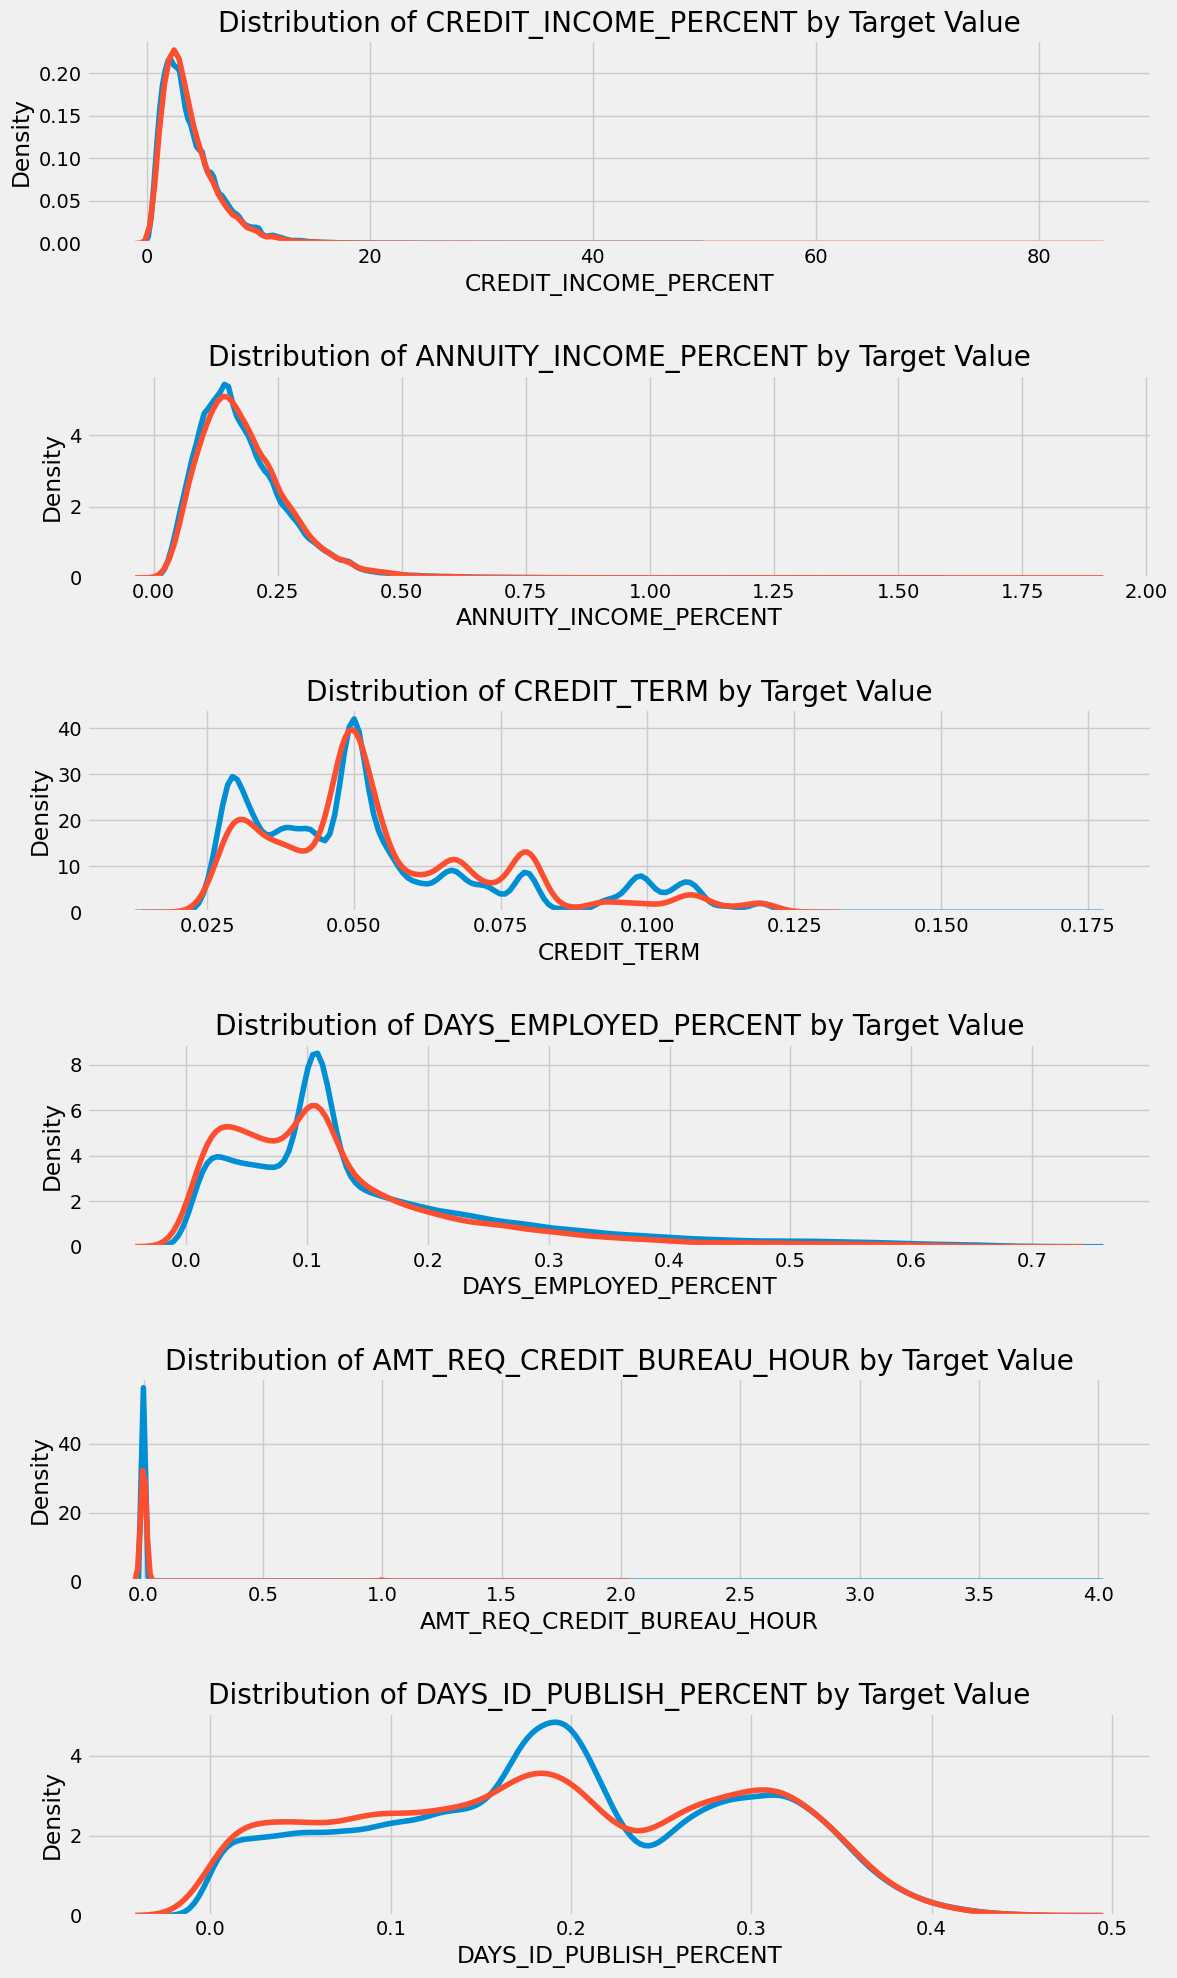

In [227]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT','AMT_REQ_CREDIT_BUREAU_HOUR','DAYS_ID_PUBLISH_PERCENT']):

    # create a new subplot for each source
    plt.subplot(6, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

<Axes: ylabel='Frequency'>

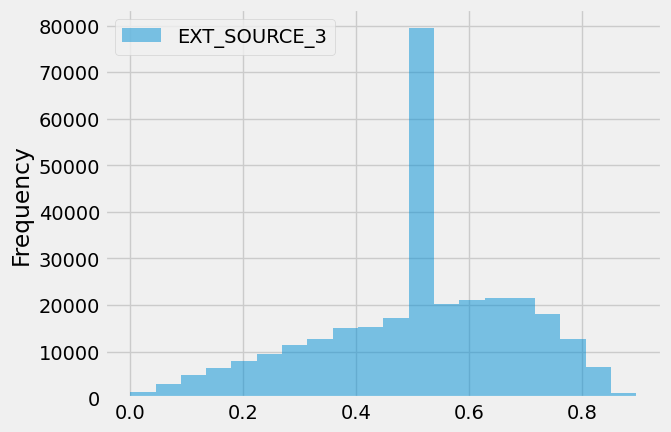

In [228]:
train_poly['EXT_SOURCE_3'].plot.hist(bins=20, alpha=0.5, legend=True)

In [229]:
train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL'] #NG
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']
train_domain['AMT_GOODS_PRICE_PERCENT'] = train_domain['AMT_GOODS_PRICE'] / train_domain['AMT_INCOME_TOTAL']

In [230]:
train_fix = train_poly.copy()

train_fix['AMT_CREDIT'] = train_domain['AMT_CREDIT']
train_fix['AMT_ANNUITY'] = train_domain['AMT_ANNUITY']
train_fix['AMT_INCOME_TOTAL'] = train_domain['AMT_INCOME_TOTAL']
train_fix['DAYS_EMPLOYED'] = train_domain['DAYS_EMPLOYED']
train_fix['DAYS_BIRTH'] = train_domain['DAYS_BIRTH']
train_fix['DEF_OBS'] = train_domain['DEF_OBS']

#train_fix['DAYS_ID_PUBLISH'] = train_domain['DAYS_ID_PUBLISH']

#train_fix['AMT_REQ_CREDIT_BUREAU_HOUR'] = train_domain['AMT_REQ_CREDIT_BUREAU_HOUR']
#train_fix['AMT_REQ_CREDIT_BUREAU_MON'] = train_domain['AMT_REQ_CREDIT_BUREAU_MON']
#train_fix['AMT_REQ_CREDIT_BUREAU_QRT'] = train_domain['AMT_REQ_CREDIT_BUREAU_QRT']
#train_fix['AMT_REQ_CREDIT_BUREAU_YEAR'] = train_domain['AMT_REQ_CREDIT_BUREAU_YEAR']

#train_fix['CREDIT_INCOME_PERCENT'] = train_domain['CREDIT_INCOME_PERCENT']
train_fix['ANNUITY_INCOME_PERCENT'] = train_domain['ANNUITY_INCOME_PERCENT']
train_fix['CREDIT_TERM'] = train_domain['CREDIT_TERM']
train_fix['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED_PERCENT']
train_fix['DAYS_ID_PUBLISH_PERCENT'] = train_domain['DAYS_ID_PUBLISH_PERCENT']
train_fix['AMT_GOODS_PRICE_PERCENT'] = train_domain['AMT_GOODS_PRICE_PERCENT']

train_fix.head(5)

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,AMT_CREDIT,AMT_ANNUITY,AMT_INCOME_TOTAL,DAYS_EMPLOYED,DEF_OBS,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,DAYS_ID_PUBLISH_PERCENT,AMT_GOODS_PRICE_PERCENT
0,1.0,0.083037,0.262949,0.139376,9461,0.006895,0.021834,0.011573,785.612748,0.069142,...,406597.5,24700.5,202500.0,637.0,1.0,0.121978,0.060749,0.067329,0.224078,1.733333
1,1.0,0.311267,0.622246,0.510853,16765,0.096887,0.193685,0.159012,5218.396475,0.387190,...,1293502.5,35698.5,270000.0,1188.0,0.0,0.132217,0.027598,0.070862,0.017358,4.183333
2,1.0,0.502130,0.555912,0.729567,19046,0.252134,0.279140,0.366337,9563.564279,0.309038,...,135000.0,6750.0,67500.0,225.0,NaN,0.100000,0.050000,0.011814,0.132889,2.000000
3,1.0,0.502130,0.650442,0.510853,19005,0.252134,0.326606,0.256514,9542.976957,0.423074,...,312682.5,29686.5,135000.0,3039.0,0.0,0.219900,0.094941,0.159905,0.128229,2.200000
4,1.0,0.502130,0.322738,0.510853,19932,0.252134,0.162057,0.256514,10008.451286,0.104160,...,513000.0,21865.5,121500.0,3038.0,NaN,0.179963,0.042623,0.152418,0.173490,4.222222


In [231]:
test_fix = test_poly.copy()

test_fix['AMT_CREDIT'] = test_domain['AMT_CREDIT']
test_fix['AMT_ANNUITY'] = test_domain['AMT_ANNUITY']
test_fix['AMT_INCOME_TOTAL'] = test_domain['AMT_INCOME_TOTAL']
test_fix['DAYS_EMPLOYED'] = test_domain['DAYS_EMPLOYED']
test_fix['DAYS_BIRTH'] = test_domain['DAYS_BIRTH']
test_fix['DEF_OBS'] = test_domain['DEF_OBS']

#test_fix['DAYS_ID_PUBLISH'] = test_domain['DAYS_ID_PUBLISH']

#test_fix['AMT_REQ_CREDIT_BUREAU_HOUR'] = test_domain['AMT_REQ_CREDIT_BUREAU_HOUR']
#test_fix['AMT_REQ_CREDIT_BUREAU_MON'] = test_domain['AMT_REQ_CREDIT_BUREAU_MON']
#test_fix['AMT_REQ_CREDIT_BUREAU_QRT'] = test_domain['AMT_REQ_CREDIT_BUREAU_QRT']
#test_fix['AMT_REQ_CREDIT_BUREAU_YEAR'] = test_domain['AMT_REQ_CREDIT_BUREAU_YEAR']

#test_fix['CREDIT_INCOME_PERCENT'] = test_domain['CREDIT_INCOME_PERCENT']
test_fix['ANNUITY_INCOME_PERCENT'] = test_domain['ANNUITY_INCOME_PERCENT']
test_fix['CREDIT_TERM'] = test_domain['CREDIT_TERM']
test_fix['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED_PERCENT']
test_fix['DAYS_ID_PUBLISH_PERCENT'] = test_domain['DAYS_ID_PUBLISH_PERCENT']
test_fix['AMT_GOODS_PRICE_PERCENT'] = test_domain['AMT_GOODS_PRICE_PERCENT']



#test_fix['OBS_CNT_SOCIAL_CIRCLE'] = test_domain['OBS_CNT_SOCIAL_CIRCLE']

test_fix.head(5)

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,AMT_CREDIT,AMT_ANNUITY,AMT_INCOME_TOTAL,DAYS_EMPLOYED,DEF_OBS,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,DAYS_ID_PUBLISH_PERCENT,AMT_GOODS_PRICE_PERCENT
0,1.0,0.752614,0.789654,0.159520,-19241,0.566429,0.594305,0.120057,-14481.055414,0.623554,...,568800.0,20560.5,135000.0,-2329.0,NaN,0.152300,0.036147,0.121044,0.042202,3.333333
1,1.0,0.564990,0.291656,0.432962,-18064,0.319214,0.164783,0.244619,-10205.983005,0.085063,...,222768.0,17370.0,99000.0,-4469.0,NaN,0.175455,0.077973,0.247398,0.089847,1.818182
2,1.0,0.501180,0.699787,0.610991,-20038,0.251181,0.350719,0.306217,-10042.641046,0.489702,...,663264.0,69777.0,202500.0,-4458.0,NaN,0.344578,0.105202,0.222477,0.174818,3.111111
3,1.0,0.525734,0.509677,0.612704,-13976,0.276396,0.267955,0.322119,-7347.658072,0.259771,...,1575000.0,49018.5,315000.0,-1866.0,NaN,0.155614,0.031123,0.133515,0.301088,5.000000
4,1.0,0.202145,0.425687,0.500106,-13040,0.040863,0.086051,0.101094,-2635.970697,0.181210,...,625500.0,32067.0,180000.0,-2191.0,NaN,0.178150,0.051266,0.168021,0.326840,3.475000


In [232]:
print("train_poly=", train_poly.shape)
print("train_fix=", train_fix.shape)

print("test_poly=",test_poly.shape)
print("test_fix=", test_fix.shape)

train_poly= (307511, 36)
train_fix= (307511, 46)
test_poly= (48744, 36)
test_fix= (48744, 46)


Flag¶

In [233]:
train_fix["NAME_EDUCATION_TYPE_Higher education"]=train["NAME_EDUCATION_TYPE_Higher education"]
test_fix["NAME_EDUCATION_TYPE_Higher education"]=test["NAME_EDUCATION_TYPE_Higher education"]

In [234]:
train_fix["FLAG_MOBIL"] = train["FLAG_MOBIL"]
train_fix["FLAG_EMP_PHONE"] = train["FLAG_EMP_PHONE"]
train_fix["FLAG_WORK_PHONE"] = train["FLAG_WORK_PHONE"]
train_fix["FLAG_CONT_MOBILE"] = train["FLAG_CONT_MOBILE"]
train_fix["FLAG_EMAIL"] = train["FLAG_EMAIL"]

test_fix["FLAG_MOBIL"] = test["FLAG_MOBIL"]
test_fix["FLAG_EMP_PHONE"] = test["FLAG_EMP_PHONE"]
test_fix["FLAG_WORK_PHONE"] = test["FLAG_WORK_PHONE"]
test_fix["FLAG_CONT_MOBILE"] = test["FLAG_CONT_MOBILE"]
test_fix["FLAG_EMAIL"] = test["FLAG_EMAIL"]

In [235]:
train_fix

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,DAYS_ID_PUBLISH_PERCENT,AMT_GOODS_PRICE_PERCENT,NAME_EDUCATION_TYPE_Higher education,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_EMAIL
0,1.0,0.083037,0.262949,0.139376,9461,0.006895,0.021834,0.011573,785.612748,0.069142,...,0.060749,0.067329,0.224078,1.733333,False,1,1,0,1,0
1,1.0,0.311267,0.622246,0.510853,16765,0.096887,0.193685,0.159012,5218.396475,0.387190,...,0.027598,0.070862,0.017358,4.183333,True,1,1,0,1,0
2,1.0,0.502130,0.555912,0.729567,19046,0.252134,0.279140,0.366337,9563.564279,0.309038,...,0.050000,0.011814,0.132889,2.000000,False,1,1,1,1,0
3,1.0,0.502130,0.650442,0.510853,19005,0.252134,0.326606,0.256514,9542.976957,0.423074,...,0.094941,0.159905,0.128229,2.200000,False,1,1,0,1,0
4,1.0,0.502130,0.322738,0.510853,19932,0.252134,0.162057,0.256514,10008.451286,0.104160,...,0.042623,0.152418,0.173490,4.222222,False,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,1.0,0.145570,0.681632,0.510853,9327,0.021191,0.099226,0.074365,1357.735625,0.464623,...,0.108198,0.025303,0.212501,1.428571,False,1,1,0,1,0
307507,1.0,0.502130,0.115992,0.510853,20775,0.252134,0.058243,0.256514,10431.746713,0.013454,...,0.044524,0.114761,0.196871,3.125000,False,1,0,0,1,0
307508,1.0,0.744026,0.535722,0.218859,14966,0.553575,0.398591,0.162837,11135.099105,0.286998,...,0.044239,0.529266,0.344113,3.823529,True,1,1,0,1,1
307509,1.0,0.502130,0.514163,0.661024,11961,0.252134,0.258176,0.331920,6005.974605,0.264363,...,0.054592,0.400134,0.077836,1.868421,False,1,1,0,1,0


## 3. 機械学習モデルの作成
ここでは、機械学習モデルの作成を行います。

まずは、必要なライブラリを読み込みます。

- train_test_split：データを訓練用データと評価用データに分割する。
- StandardScaler：データを標準化する。
- roc_auc_score：今回の評価指標であるAUCを計算する。

In [236]:
# ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Make Predictions using Engineered Features

The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.


In [237]:
train_fix.isnull().sum()

1                                              0
EXT_SOURCE_1                                   0
EXT_SOURCE_2                                   0
EXT_SOURCE_3                                   0
DAYS_BIRTH                                     0
EXT_SOURCE_1^2                                 0
EXT_SOURCE_1 EXT_SOURCE_2                      0
EXT_SOURCE_1 EXT_SOURCE_3                      0
EXT_SOURCE_1 DAYS_BIRTH                        0
EXT_SOURCE_2^2                                 0
EXT_SOURCE_2 EXT_SOURCE_3                      0
EXT_SOURCE_2 DAYS_BIRTH                        0
EXT_SOURCE_3^2                                 0
EXT_SOURCE_3 DAYS_BIRTH                        0
DAYS_BIRTH^2                                   0
EXT_SOURCE_1^3                                 0
EXT_SOURCE_1^2 EXT_SOURCE_2                    0
EXT_SOURCE_1^2 EXT_SOURCE_3                    0
EXT_SOURCE_1^2 DAYS_BIRTH                      0
EXT_SOURCE_1 EXT_SOURCE_2^2                    0
EXT_SOURCE_1 EXT_SOU

In [238]:
train_fix

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,DAYS_ID_PUBLISH_PERCENT,AMT_GOODS_PRICE_PERCENT,NAME_EDUCATION_TYPE_Higher education,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_EMAIL
0,1.0,0.083037,0.262949,0.139376,9461,0.006895,0.021834,0.011573,785.612748,0.069142,...,0.060749,0.067329,0.224078,1.733333,False,1,1,0,1,0
1,1.0,0.311267,0.622246,0.510853,16765,0.096887,0.193685,0.159012,5218.396475,0.387190,...,0.027598,0.070862,0.017358,4.183333,True,1,1,0,1,0
2,1.0,0.502130,0.555912,0.729567,19046,0.252134,0.279140,0.366337,9563.564279,0.309038,...,0.050000,0.011814,0.132889,2.000000,False,1,1,1,1,0
3,1.0,0.502130,0.650442,0.510853,19005,0.252134,0.326606,0.256514,9542.976957,0.423074,...,0.094941,0.159905,0.128229,2.200000,False,1,1,0,1,0
4,1.0,0.502130,0.322738,0.510853,19932,0.252134,0.162057,0.256514,10008.451286,0.104160,...,0.042623,0.152418,0.173490,4.222222,False,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,1.0,0.145570,0.681632,0.510853,9327,0.021191,0.099226,0.074365,1357.735625,0.464623,...,0.108198,0.025303,0.212501,1.428571,False,1,1,0,1,0
307507,1.0,0.502130,0.115992,0.510853,20775,0.252134,0.058243,0.256514,10431.746713,0.013454,...,0.044524,0.114761,0.196871,3.125000,False,1,0,0,1,0
307508,1.0,0.744026,0.535722,0.218859,14966,0.553575,0.398591,0.162837,11135.099105,0.286998,...,0.044239,0.529266,0.344113,3.823529,True,1,1,0,1,1
307509,1.0,0.502130,0.514163,0.661024,11961,0.252134,0.258176,0.331920,6005.974605,0.264363,...,0.054592,0.400134,0.077836,1.868421,False,1,1,0,1,0


In [239]:
test_fix

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,DAYS_ID_PUBLISH_PERCENT,AMT_GOODS_PRICE_PERCENT,NAME_EDUCATION_TYPE_Higher education,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_EMAIL
0,1.0,0.752614,0.789654,0.159520,-19241,0.566429,0.594305,0.120057,-14481.055414,0.623554,...,0.036147,0.121044,0.042202,3.333333,True,1,1,0,1,1
1,1.0,0.564990,0.291656,0.432962,-18064,0.319214,0.164783,0.244619,-10205.983005,0.085063,...,0.077973,0.247398,0.089847,1.818182,False,1,1,0,1,0
2,1.0,0.501180,0.699787,0.610991,-20038,0.251181,0.350719,0.306217,-10042.641046,0.489702,...,0.105202,0.222477,0.174818,3.111111,True,1,1,0,1,0
3,1.0,0.525734,0.509677,0.612704,-13976,0.276396,0.267955,0.322119,-7347.658072,0.259771,...,0.031123,0.133515,0.301088,5.000000,False,1,1,0,1,0
4,1.0,0.202145,0.425687,0.500106,-13040,0.040863,0.086051,0.101094,-2635.970697,0.181210,...,0.051266,0.168021,0.326840,3.475000,False,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,1.0,0.501180,0.648575,0.643026,-19970,0.251181,0.325053,0.322271,-10008.560818,0.420649,...,0.042354,0.258838,0.170205,2.222222,False,1,1,1,1,0
48740,1.0,0.501180,0.684596,0.500106,-11186,0.251181,0.343106,0.250643,-5606.197362,0.468671,...,0.051267,0.102718,0.268461,3.142857,False,1,1,0,1,0
48741,1.0,0.733503,0.632770,0.283712,-15922,0.538027,0.464139,0.208104,-11678.842724,0.400397,...,0.105414,0.190742,0.094460,1.555556,False,1,1,0,1,0
48742,1.0,0.373090,0.445701,0.595456,-13968,0.139196,0.166287,0.222159,-5211.322249,0.198649,...,0.055840,0.195518,0.097652,2.000000,True,1,1,1,1,0


データを説明変数と目的変数に分割します。今回の目的変数は「TARGET」なので、それ以外が説明変数となります。

In [240]:
# 目的変数と説明変数に分割
#X = train_poly.drop("TARGET", axis=1).values
# = train_poly["TARGET"].values
#X = train_fix2.values
#X = train_fix.drop("TARGET", axis=1).values
X = train_fix
y = train["TARGET"].values
X_test = test_fix.values
X

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,DAYS_ID_PUBLISH_PERCENT,AMT_GOODS_PRICE_PERCENT,NAME_EDUCATION_TYPE_Higher education,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_EMAIL
0,1.0,0.083037,0.262949,0.139376,9461,0.006895,0.021834,0.011573,785.612748,0.069142,...,0.060749,0.067329,0.224078,1.733333,False,1,1,0,1,0
1,1.0,0.311267,0.622246,0.510853,16765,0.096887,0.193685,0.159012,5218.396475,0.387190,...,0.027598,0.070862,0.017358,4.183333,True,1,1,0,1,0
2,1.0,0.502130,0.555912,0.729567,19046,0.252134,0.279140,0.366337,9563.564279,0.309038,...,0.050000,0.011814,0.132889,2.000000,False,1,1,1,1,0
3,1.0,0.502130,0.650442,0.510853,19005,0.252134,0.326606,0.256514,9542.976957,0.423074,...,0.094941,0.159905,0.128229,2.200000,False,1,1,0,1,0
4,1.0,0.502130,0.322738,0.510853,19932,0.252134,0.162057,0.256514,10008.451286,0.104160,...,0.042623,0.152418,0.173490,4.222222,False,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,1.0,0.145570,0.681632,0.510853,9327,0.021191,0.099226,0.074365,1357.735625,0.464623,...,0.108198,0.025303,0.212501,1.428571,False,1,1,0,1,0
307507,1.0,0.502130,0.115992,0.510853,20775,0.252134,0.058243,0.256514,10431.746713,0.013454,...,0.044524,0.114761,0.196871,3.125000,False,1,0,0,1,0
307508,1.0,0.744026,0.535722,0.218859,14966,0.553575,0.398591,0.162837,11135.099105,0.286998,...,0.044239,0.529266,0.344113,3.823529,True,1,1,0,1,1
307509,1.0,0.502130,0.514163,0.661024,11961,0.252134,0.258176,0.331920,6005.974605,0.264363,...,0.054592,0.400134,0.077836,1.868421,False,1,1,0,1,0


データを標準化します。標準化とは、平均が0で分散が1となるように値を変換する操作です。ロジスティック回帰やニューラルネットワークなどの一部のモデルでは、このように値のスケールを揃えないと学習が上手くいきません。

In [241]:
# 標準化
#sc = StandardScaler()
#sc.fit(X)
#X_std = sc.transform(X)
#X_test_std = sc.transform(X_test)

学習用データのうち、7割を訓練データ、3割を評価データとして分割します。このように、学習データの一部を学習に用いずに、評価用として取っておく手法をホールドアウト法と呼びます。これにより、未知のデータに対する予測精度（汎化性能）を算出することが出来ます。

In [242]:
# 訓練データと評価データに分割
#X_train, X_valid, y_train, y_valid = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)


ロジスティック回帰と多層パーセプトロンでモデルを作成してみます。

In [243]:
#from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score
from sklearn import metrics

# 重回帰のモデル構築のためのインポート
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

BaseLine_model =XGBoost

In [244]:
# LogisticRegression
#from sklearn.linear_model import LogisticRegression

#lr = LogisticRegression(random_state=0)
#lr.fit(X_train, y_train)

#lr_train_pred = lr.predict_proba(X_train)[:, 1]
#lr_valid_pred = lr.predict_proba(X_valid)[:, 1]
#print(f"Train Score: {roc_auc_score(y_train, lr_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, lr_valid_pred)}")

In [245]:
# MLPClassifier
#from sklearn.neural_network import MLPClassifier

#mlp = MLPClassifier(random_state=0)
#mlp.fit(X_train, y_train)

#mlp_train_pred = mlp.predict_proba(X_train)[:, 1]
#mlp_valid_pred = mlp.predict_proba(X_valid)[:, 1]
#print(f"Train Score: {roc_auc_score(y_train, mlp_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, mlp_valid_pred)}")

つぎに、勾配ブースティング木（GBDT）と呼ばれるモデルを作成してみたいと思います。GBDTは、使いやすさと精度の高さから、Kaggleなどの分析コンペでよく使用されているモデルです。GBDTの特徴として以下のような点が挙げられます。
- 欠損値のあるデータを学習できる。
- 標準化などの値のスケーリングが不要。
- 精度が高い。
- 特徴量間の相互作用が反映される。
- 特徴量が多くても精度が落ちにくく、速度が速い。

今回はGBDTの中でも代表的なxgboostとlightgbmを扱います。

In [246]:
# XGBClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0)
#xgb.fit(X_train, y_train)

#xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
#xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]
#print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, xgb_valid_pred)}")

In [247]:
#GBM
#from sklearn.ensemble import GradientBoostingClassifier

#gb = GradientBoostingClassifier(random_state=0)
#gb.fit(X_train, y_train)

#gb_train_pred = gb.predict_proba(X_train)[:, 1]
#gb_valid_pred = gb.predict_proba(X_valid)[:, 1]
#print(f"Train Score: {roc_auc_score(y_train, gb_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, gb_valid_pred)}")

In [248]:
# LGBMClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

#lgb = LGBMClassifier(random_state=0)

#lgb.fit(X_train, y_train)
#lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
#lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
#print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

In [249]:
# LightGBMのインポート
#import lightgbm as lgb

# グリッドサーチのインポート
#from sklearn.model_selection import GridSearchCV

# パラメータの準備
#parameters = {
    #'max_depth': [6, 8, 10, 12, 15, 20, 30],
    #'min_data_in_leaf': [20, 25, 30, 35, 40, 45, 50, 55, 60],
    #'num_leaves': [20, 30, 40, 50, 60]
#    'max_depth': [6, 8, 10, 12],
#    'min_data_in_leaf': [20, 25, 30, ],
#    'num_leaves': [20, 30, 40, 60]

#}

# グリッドサーチの設定
#lgb = GridSearchCV(LGBMClassifier(random_state=42), parameters, cv=5, scoring='roc_auc', return_train_score=True)

# グリッドサーチの実行
#lgb.fit(X_train, y_train)

#lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
#lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]

#print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

ここまでで、4つのモデルを作成しました。ここでは、アンサンブルと呼ばれる複数のモデルを組み合わせることを行います。アンサンブルには、様々な手法がありますが、今回はシンプルに4つのモデルの平均値をとることにします。

In [250]:
#train_pred = (lr_train_pred + mlp_train_pred + lgb_train_pred + xgb_train_pred)/4
#valid_pred = (lr_valid_pred + mlp_valid_pred + lgb_valid_pred + xgb_valid_pred)/4

#train_pred = (lr_train_pred + lgb_train_pred + xgb_train_pred)/3
#valid_pred = (lr_valid_pred + lgb_valid_pred + xgb_valid_pred)/3

#train_pred = (lgb_train_pred + xgb_train_pred)/2
#valid_pred = (lgb_valid_pred + xgb_valid_pred)/2

#print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
#print(f"Valid Score: {roc_auc_score(y_valid, valid_pred)}")

今回は、アンサンブルをしても精度の向上には繋がらなかったため、最終的なモデルは一番スコアの高かったxgboostを用いることにします。

やっぱり多様なModelを試してみる

In [251]:
# リッジ回帰用のクラス
# モデルの構築と評価
#linear = LinearRegression()
#ridge = Ridge(random_state=0)

#for model in [linear, ridge]:
#    model.fit(X_train, y_train)
#    print('{}(train):{:.6f}'.format(model.__class__.__name__ , model.score(X_train, y_train)))
#    print('{}(test):{:.6f}'.format(model.__class__.__name__ , model.score(X_valid, y_valid)))

In [252]:
# グリッドサーチのインポート
#from sklearn.model_selection import GridSearchCV
#
# パラメータの準備
#parameters = {
#    'max_depth': [6, 8, 10, 12, 15, 20, 30],
#    'min_data_in_leaf': [20, 25, 30, 35, 40, 45, 50, 55, 60],
#    'num_leaves': [20, 30, 40, 50, 60]
#}
#
# グリッドサーチの設定
#lgb_gcv = GridSearchCV(lgb, parameters, cv=5, scoring='roc_auc', return_train_score=True)

# グリッドサーチの実行
#lgb_gcv.fit(X_train, y_train)

LightGBM最適化

In [253]:
!pip install optuna optuna-integration

In [254]:
import optuna
import optuna.integration.lightgbm as lgb_tune
#LightGBM のハイパーパラメータ
#params = {
    # 二値分類問題
#    'objective': 'binary',
    # AUC の最大化を目指す
#    'metric': 'auc',
    # Fatal の場合出力
#    'verbosity': -1,
#}

# データセットを生成する
#lgb_train = lgb_tune.Dataset(X_train, y_train)
#lgb_valid = lgb_tune.Dataset(X_valid, y_valid, reference=lgb_train)
#
#model_tune = lgb_tune.train(params, lgb_train, valid_sets=lgb_valid,
#                  num_boost_round=250,  # 最大イテレーション回数指定
#                  callbacks=[lgb_tune.early_stopping(100), lgb_tune.log_evaluation(period=100)]# ここが変わった
#                 )

In [255]:
#model_tune.params

In [256]:
#lgb=LGBMClassifier(model_tune.params)

lgb=LGBMClassifier(
    objective='binary',
    metric='auc',
    verbosity=-1,
    feature_pre_filter= False,
    lambda_l1=3.4104180323501025,
    lambda_l2=9.554112700436095,
    num_leaves=31,
    feature_fraction=0.4,
    bagging_fraction=1.0,
    bagging_freq=0,
    min_child_samples=5,
    num_iterations=250)

In [257]:
models = [
    #("GBM", GradientBoostingClassifier(random_state=42)),
    #("Histogram Boosting", HistGradientBoostingClassifier(random_state=42)),
    #("SVM", SVC(probability=True, random_state=42)),
    #("XGBoost", XGBClassifier(random_state=42)),
    ("XGBoost", xgb),
    #("Catboost", CatBoostClassifier(verbose=0, random_state=42)),
    #("Regression", LogisticRegression(max_iter=600, random_state=42)),
    #("Random Forest", RandomForestClassifier(random_state=42)),
    #("K-Nearest", KNeighborsClassifier()),
    #("LGBMClassifier",LGBMClassifier(boosting_type='goss',random_state=42, verbose=-1))
    ("LGBMClassifier",lgb)
    #("MLPClassifier", MLPClassifier(hidden_layer_sizes=(100, 100, 10), random_state=42))
]
#ridge = Ridge(random_state=0)
for i, (name, model) in enumerate(models, 1):
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)[:, 1]
    valid_pred = model.predict_proba(X_valid)[:, 1]
    print(f"Train Score: {roc_auc_score(y_train, train_pred)} - {name}")
    print(f"Valid Score: {roc_auc_score(y_valid, valid_pred)} - {name}")

Train Score: 0.8620298780179183 - XGBoost
Valid Score: 0.7497411551335476 - XGBoost
Train Score: 0.815971981254157 - LGBMClassifier
Valid Score: 0.7613635517347952 - LGBMClassifier


Croaa Validation

In [258]:
#    scores[(model_name, 'cross_val_score')] = cross_val_score(model, X_train, y_train, cv=5).mean()
#roc_auc_score_cv = cross_val_score(lgb, X, y, scoring="roc_auc", cv=5).mean()
#print(f"ROC_AUC_Score Train: {roc_auc_score_cv} - cross valivation")

In [259]:
#scores = cross_val_score(lightgbm, features, target, cv=3,scoring='neg_mean_squared_error')
#roc_auc_score_train = cross_val_score(lgb, X_train, y_train, cv=5).max()
#roc_auc_score_pred = cross_val_score(lgb, X_valid, y_valid, cv=5).max()

In [260]:
#voting_clf = VotingClassifier(estimators=models, voting='soft')
#voting_clf.fit(X_train, y_train)

#roc_auc_score_train = cross_val_score(voting_clf, X_train, y_train, cv=5).max()
#roc_auc_score_pred = cross_val_score(voting_clf, X_valid, y_valid, cv=5).max()

#print(f"ROC_AUC_Score Train: {roc_auc_score_train} - Voting")
#print(f"ROC_AUC_Score Pred: {roc_auc_score_pred} - Voting")


## 4. 予測結果の作成
最後にテストデータに対して予測を行い、提出用のcsvファイルを作成します。

In [261]:
# テストデータに対する予測値の作成
#pred = xgb.predict_proba(X_test)[:, 1]
#pred= voting_clf.predict_proba(X_test)[:, 1]
#pred= voting_clf.predict_proba(X_test_std)[:, 1]
#pred = lgb.predict_proba(X_test)[:, 1]

In [262]:
#lr_pred   = lr.predict_proba(X_test)[:, 1]
lgb_pred  = lgb.predict_proba(X_test)[:, 1]
xgb_pred = xgb.predict_proba(X_test)[:, 1]

#pred = (lgb_pred + xgb_pred)/2.0

pred = 0.8*lgb_pred + 0.2*xgb_pred

In [263]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred
sample_sub

,SK_ID_CURR,TARGET
0,100001,0.042617
1,100005,0.065681
2,100013,0.104766
3,100028,0.058470
4,100038,0.122970
...,...,...
48739,456221,0.049804
48740,456222,0.061649
48741,456223,0.037859
48742,456224,0.031045


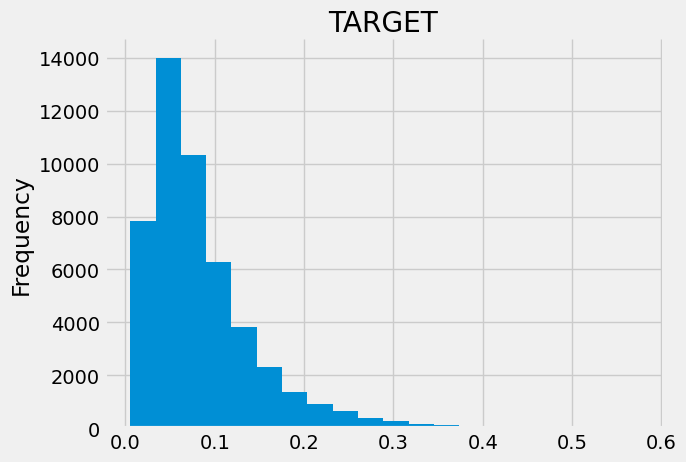

In [264]:
from matplotlib import pyplot as plt
sample_sub['TARGET'].plot(kind='hist', bins=20, title='TARGET')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [265]:
# 提出用のcsvファイルを作成
#sample_sub.to_csv('sub_competition2.csv',index=False)
if key_kaggle == True:
  sample_sub.to_csv('sub_competition2_kaggle.csv',index=False)
else:
  sample_sub.to_csv('sub_competition2.csv',index=False)

以上で、Home Credit Default Riskコンペのチュートリアルは終了です。今回は、50種類ある特徴量のうち5種類しか使用していないので、まだまだ改善の余地があります。この後は、このnotebookやこれまでの教材を参考にして、さらなるスコアの向上を目指してください！

In [266]:
from google.colab import files
#files.download('sub_competition2.csv')
if key_kaggle == True:
  files.download('sub_competition2_kaggle.csv')
else:
  files.download('sub_competition2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>